## Imports

In [1]:
import ast
import pandas as pd
import numpy as np
import os
from os.path import abspath, join
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
from tqdm import tqdm
from matplotlib.figure import Figure
import pickle

from nipype.interfaces import fsl
from nipype.testing import example_data

from nilearn import image, plotting
from nilearn.image import get_data
from nilearn.image import load_img, math_img

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use("ggplot")
import seaborn as sns
import ptitprince as pt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from itertools import combinations
from hamcrest import *
import unittest
from scipy import stats
from statsmodels.stats.anova import AnovaRM

## Folder structure

In [2]:
experiment_dir = '/data/tu_aljedawi/DLT/'

participants = ['P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039',
                'P054', 'P055', 'P056', 'P057', 'P059', 'P061', 'P062', 'P063', 'P064',
                'P065', 'P066', 'P070', 'P071', 'P072', 'P073', 'P074', 'P075', 'P076']

logs_dir = experiment_dir + "data/behavior/logs/day_learning/"
behv_dir = experiment_dir + "data/behavior/"

# (master) functional space directory
if not os.path.exists(experiment_dir + "data/mri/functional_space"):
    os.makedirs(experiment_dir + "data/mri/functional_space") 
output_dir = experiment_dir + "data/mri/functional_space/"

# python objects directory
if not os.path.exists(output_dir + "python_objects"):
    os.makedirs(output_dir + "python_objects")
po_dir = output_dir + "python_objects/"

# freesurfer ROIs directory
rois_fs = ["hpc", "ec"]
for i_roi in rois_fs:
    if not os.path.exists(output_dir + "%s_lr" % i_roi):
        os.makedirs(output_dir + "%s_lr" % i_roi)

# MNI ROIs directory
#rois_mni = ["aHPC", "alEC"]
#rois_mni = ["pHPC", "pmEC"]
rois_mni = ["aHPC", "alEC", "pHPC", "pmEC"]
for i_roi in rois_mni:
    if not os.path.exists(output_dir + "mni/%s_lr" % i_roi):
        os.makedirs(output_dir + "mni/%s_lr" % i_roi)
    
    # intersected masks directory
    if not os.path.exists(output_dir + "intersected_masks/%s_lr" % i_roi):
        os.makedirs(output_dir + "intersected_masks/%s_lr" % i_roi)
    
    # timeseries directory
    if not os.path.exists(output_dir + "time_series/%s_lr" % i_roi):
        os.makedirs(output_dir + "time_series/%s_lr" % i_roi)
        
    # correlation matrices directory
    if not os.path.exists(output_dir + "correlation_matrices/%s_lr" % i_roi):
        os.makedirs(output_dir + "correlation_matrices/%s_lr" % i_roi)

# Loading Temporal Logs
Load the temporal logs data from the relevant text files into a dictionary with the participant's number as the dictionary `key` and a dataframe of the participant's logs data as its `value`. Following this format: `logs = {'P0XX' : DataFrame[...]}`

In [3]:
%%time

logs = {}
for filename in os.listdir(logs_dir):
    if filename.endswith(".txt") and filename.startswith(tuple(participants)):
        key = filename.split('-')[0]
        data = pd.read_csv(os.path.join(logs_dir,filename), sep="\t", header=None)
        data.columns =['fc_on', 'fc_off', 'cue_start', 'cue_id', 'blkscrn_on', 'volume',
                       'repetition', 'real_time', 'virtual_day', 'trial_endtime']
        logs[key] = data
        
    else:
        continue

#logs.items()

CPU times: user 167 ms, sys: 20 ms, total: 187 ms
Wall time: 409 ms


In [4]:
logs['P064'].head()

,fc_on,fc_off,cue_start,cue_id,blkscrn_on,volume,repetition,real_time,virtual_day,trial_endtime
0,20793,24266,24266,8.33,25782,12,1,3.4649,2,25782
1,25782,30182,30204,13.00,31705,14,1,9.3750,2,31705
2,31705,33715,33716,10.04,35232,16,1,12.9010,2,35232
3,35232,39565,39587,18.00,41098,19,1,18.7500,2,41098
4,41098,51014,51015,12.50,52531,24,1,30.2088,2,52531


# Regions of Interest (ROI)

We want to combine masks from the individual Freesurfer segmentations of the HPC and EC with masks dividing the subregions of the HPC and EC.

The participants' Freesurfer masks are saved in /data/mri/rois/hpc_lr/freesurfer_highres_space, and the standard MNI masks are saved in /data/mri/rois/mni_masks. All masks will be co-registered to the analysis space, which is the space of the functional images. This relies on the FSL transformation matrices and warp files stored in the /data/mri/processed for each participant.

**1. Apply flirt**   
To co-register both Freesurfer and standard MNI masks to the functional space.


**2. Binarize the outputs**   
Before intersecting the resulting ROIs from previous steps, we first need to binarize the masked ROIs using a threshold. We chose this threshold to be 0.5 in this case. This step is required because the previous co-registeration steps resulted in matrices of type float due to the mathmatical transformations that were applied on the masks.  

**3. Intersect the binarized output masks**  

In [5]:
def flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat):
    flt = fsl.FLIRT(apply_xfm=True, verbose=0)
    flt.inputs.in_file = input_dir
    flt.inputs.reference = ref_dir
    flt.inputs.in_matrix_file = mat_dir
    flt.inputs.out_file = out_file
    flt.inputs.out_matrix_file = out_mat
    #print(flt.cmdline)
    result = flt.run()
    return result

## Coregister Freesurfer masks to functional space

In [6]:
%%time

# threshold for binarizing the output masks
threshold = 0.5

# ROIs of freesrufer masks
rois_fs = ["hpc", "ec"]


def run_highres2func():
    for i_roi in rois_fs:
        #print(i_roi)
        working_dir = join(output_dir,"%s_lr/" %(i_roi))
        i=0

        for p in participants:
            i+=1
            input_dir = join(experiment_dir, "data/mri/rois/%s_lr/freesurfer_highres_space/%s_%s_lr_fs_hs.nii.gz" % (i_roi,p,i_roi))
            #print(str(i) + input_dir)
            ref_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/example_func.nii.gz" % p)
            #print(str(i) + ref_dir)
            mat_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/reg/highres2example_func.mat" % p)
            #print(str(i) + mat_dir)
            out_file = join(working_dir, "%s_%s_fs.nii.gz" % (p,i_roi))
            #print(str(i) + out_file)
            out_mat = join(working_dir, "%s_%s_fs_hs_flirt.mat" % (p,i_roi))
            #print(str(i) + out_mat)
            res = flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat)
            #print(res.outputs)

            # use math_img to binarize the masked ROIs using a threshold of 0.5
            binary_mask = math_img(f'img > {threshold}', img=out_file)
            binary_mask.to_filename(join(working_dir, "%s_%s_fs_binary.nii.gz" % (p,i_roi)))
            
#run_highres2func()

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 18.6 µs


## Atlas masks

In [7]:
%%time

def run_standard2func():
    for i_roi in rois_mni:
        #print(i_roi)
        working_dir = join(output_dir,"mni/%s_lr/" %(i_roi))
        i=0

        for p in participants:
            i+=1
            input_dir = join(experiment_dir, "data/mri/rois/mni_masks/%s_lr.nii.gz" % (i_roi))
            #print(str(i) + input_dir)
            ref_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/example_func.nii.gz" % p)
            #print(str(i) + ref_dir)
            mat_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/reg/standard2example_func.mat" % p)
            #print(str(i) + mat_dir)
            out_file = join(working_dir, "%s_%s_mni.nii.gz" % (p,i_roi))
            #print(str(i) + out_file)
            out_mat = join(working_dir, "%s_%s_mni_flirt.mat" % (p,i_roi))
            #print(str(i) + out_mat)
            res = flirt_apply(input_dir, ref_dir, mat_dir, out_file, out_mat)
            #print(res.outputs)

            # use math_im to binarize the masked ROIs using a threshold of 0.5
            binary_mask = math_img(f'img > {threshold}', img=out_file)
            binary_mask.to_filename(join(working_dir, "%s_%s_mni_binary.nii.gz" % (p,i_roi)))
            
#run_standard2func()

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 14.8 µs


## Intersecting the masks
In the last step, we intersect the masks from Freesurfer with the respective subregion masks. At this point, both masks are in the functional analysis space and have been binarized. Finally, we generate a PDF of diagnostic plots to check the final ROI masks.

In [8]:
%%time

rois_fs = {"aHPC":"hpc", "pHPC":"hpc", "alEC":"ec", "pmEC":"ec"}
roi_imgs = []
titles = []
bg_imgs = []

imasks = {}

for i_roi in rois_mni:
    imasks.update( {i_roi:{p:0 for p in participants}} )
    
    working_dir = join(output_dir,"intersected_masks/%s_lr/" %(i_roi))
    #print(working_dir)
    f_roi = rois_fs[i_roi]
    
    for p in participants:
        fs = load_img(join(output_dir, "%s_lr/%s_%s_fs_binary.nii.gz" %(f_roi,p,f_roi)))
        mn = load_img(join(output_dir, "mni/%s_lr/%s_%s_mni_binary.nii.gz" %(i_roi,p,i_roi)))
        intersec_mask = math_img('img1 * img2', img1=fs, img2=mn)
        intersec_mask.to_filename(join(working_dir, "%s_%s.nii.gz" %(p,i_roi)))
        #print("out_file =", join(working_dir,"%s_%s.nii.gz" %(p,i_roi)))
        imasks[i_roi][p] = intersec_mask
        
        # saving the outputs to generate a PDF of diagnostic plots of the final ROI masks
        roi_img = join(working_dir,"%s_%s.nii.gz" %(p,i_roi))
        bg_img = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mean_func.nii.gz" %p)
        t = ("%s_%s" %(p,i_roi))
        roi_imgs.append(roi_img)
        bg_imgs.append(bg_img)
        titles.append(t)

with open(join(po_dir, "intersected_masks_all.pickle"),"wb") as f:
    pickle.dump(imasks, f)

print("Finished interesecting a total of %d ROI masks in the functional space" % len(roi_imgs))

#imasks

Finished interesecting a total of 108 ROI masks in the functional space
CPU times: user 30.7 s, sys: 1.21 s, total: 31.9 s
Wall time: 36.4 s


In [9]:
#imasks

### PDF of diagnostic plots generation

In [10]:
%%time

# Plot multiple figures into a single PDF with matplotlib, using the object-oriented interface
plts = zip(roi_imgs, titles, bg_imgs)

def pdf_diagnostics():
    with PdfPages(join(output_dir,"intersected_masks/ROIs_ALL.pdf")) as pages:
        for pl in plts:
            fig = Figure()
            ax = fig.gca()
            plotting.plot_roi(pl[0],title=pl[1], display_mode='ortho', annotate=False, draw_cross=False,
                              cmap="cool", black_bg=True, bg_img=pl[2], axes=ax)
            canvas = FigureCanvasPdf(fig)
            canvas.print_figure(pages)

    print("PDF of diagnostic plots of the final ROI masks is generated in:\n",
          join(output_dir,"intersected_masks/ROIs_ALL.pdf"))

# (approx. 4min 17s)
#pdf_diagnostics()

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 17.9 µs


# Get multi-voxel patterns from ROIs

In [11]:
# a custom function similar to FSL_info func
def fsl_info(arr):
    # Printing type of arr object
    print("Array is of type: ", type(arr))
    # Printing array dimensions (axes)
    print("No. of dimensions: ", arr.ndim)
    # Printing shape of array
    print("Shape of array: ", arr.shape)
    # Printing size (total number of elements) of array
    print("Size of array: ", arr.size)
    # Printing type of elements in array
    print("Array stores elements of type: ", arr.dtype)

## Extract ROI time series

 0. Load all filtered_func, masks matrices
 1. a = Reduce my intersected mask matrix to 1D vector
 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
 4. Output is: P064_aHPC_timeseries, save them as csv or pickle

In [12]:
%%time
RELOAD_DATA = False

# define load_filteredfunc_data function
# What it does:
# Loads the functional data (filtered_func NIFTIs) for all participants and pickle it out as a Python object
def load_filteredfunc_data():
    filtered_func_all = {}
    filtered_func_all = {p:0 for p in participants}

    for p in participants:
        ffunc_nii = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/filtered_func_data.nii.gz" %p)
        ffunc_data = get_data(ffunc_nii)
        filtered_func_all[p] = ffunc_data
    
    with open(join(po_dir, "filtered_func_all.pickle"),"wb") as f:
        pickle.dump(filtered_func_all, f)
    return filtered_func_all
        


if not os.path.exists(join(po_dir, "filtered_func_all.pickle")) or RELOAD_DATA:
    print("Loading functional data for the first time (approx. 35 min)")
    filtered_func_all = load_filteredfunc_data()
    
else:
    print("Loading saved functional data (approx. 5 min)")
    with open(join(output_dir, "python_objects/filtered_func_all.pickle"),"rb") as f:
        filtered_func_all = pickle.load(f)

#dict(list(filtered_func_all.items())[0:2])

Loading saved functional data (approx. 5 min)
CPU times: user 1min 3s, sys: 3min 17s, total: 4min 20s
Wall time: 5min 8s


In [13]:
%%time

def create_fmri_timeseries():
    for i_roi in rois_mni:
        print(i_roi)
        working_dir = join(output_dir,"time_series/%s_lr/" %(i_roi))

        for p in participants:
            #print(p)
            a = get_data(imasks[i_roi][p])
            b = filtered_func_all[p]

            # 1. a = Reduce my intersected mask matrix to 1D vector
            a_re = np.reshape(a, a.size)

            # 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
            b_re = np.reshape(b, (b.shape[0]*b.shape[1]*b.shape[2], b.shape[-1]))

            # 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
            b_timeseries = b_re[(a_re == 1),:]

            # 4. Output example is: P064_aHPC_timeseries, save it as csv
            np.savetxt(join(working_dir, "%s_%s_timeseries.csv" % (p,i_roi)), b_timeseries, delimiter=",")


# (approx. 34min 34s)
#create_fmri_timeseries()

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 21.7 µs


In [14]:
%%time

# Test the output of create_fmri_timeseries function for one participant

p_test = "P064"
i_roi_test = "aHPC"

a_test = get_data(imasks[i_roi_test][p_test])
b_test = filtered_func_all[p_test]

# 1. a = Reduce my intersected mask matrix to 1D vector
a_re_test = np.reshape(a_test, a_test.size)

# 2. b = Reduce filtered_func matrix to 2D (D1xD2xD3 , D4)
b_re_test = np.reshape(b_test, (b_test.shape[0]*b_test.shape[1]*b_test.shape[2], b_test.shape[-1]))

# 3. Apply my (a) logical vector to my (b) reduced filtered matrix to reduce it even further
b_timeseries_test = b_re_test[(a_re_test == 1),:]

print("For participant "+ p_test + " (" + i_roi_test + "):")
print("1) a.shape:", a_test.shape)
print("1) a_reduced.shape:", a_re_test.shape)
print("\n2) b.shape:", b_test.shape)
print("2) b_reduced.shape:", b_re_test.shape)
print("\n3) b_timeseries.shape:", b_timeseries_test.shape)

For participant P064 (aHPC):
1) a.shape: (140, 140, 40)
1) a_reduced.shape: (784000,)

2) b.shape: (140, 140, 40, 1078)
2) b_reduced.shape: (784000, 1078)

3) b_timeseries.shape: (751, 1078)
CPU times: user 40.3 s, sys: 14.5 s, total: 54.8 s
Wall time: 55 s


## Calculate residuals from motion parameter regression
The purpose of this step is to remove the chuncks from my ROI timeseries that can be explained by motion.

 1. Build a linear model to predict voxels time series using MC parameters
 2. Visualize your timeseries against your model prediction
 3. Take my residuals as the cleaned up data 
 4. Output is: P064_aHPC_timeseries_cleaned, save it as csv

In [15]:
# load the ROI timeseries (combined mask)
def read_timeseries(participant, roi):
    file = join(output_dir,"time_series/%s_lr/%s_%s_timeseries.csv" % (roi,participant,roi))
    df = pd.read_csv(file, header=None)
    return df

print(p)
print(i_roi)
roi_dat = read_timeseries(p, i_roi)
print(roi_dat.shape)
roi_dat.head()

P076
pmEC
(80, 1079)


,0,1,2,3,4,5,6,7,8,9,...,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078
0,5952.754883,7256.418457,5401.515625,5598.888672,5561.208496,5620.530762,6340.106445,6376.847168,6061.357910,5223.265625,...,6267.877930,4944.083984,7027.285156,5961.851562,5429.938965,5304.953613,5758.128418,5786.164062,7482.230469,6173.794434
1,4119.958984,4746.083008,3745.886475,4447.646973,3847.179932,5284.935059,4607.393066,3378.437012,4675.532715,5923.081543,...,4176.163086,3584.987061,4305.213867,4954.328613,4097.900391,4450.118652,4938.595215,4669.974609,3923.336670,3623.924072
2,6507.108887,5435.052734,7863.061035,6388.736328,5784.131836,7606.416504,6671.803711,6894.424316,5705.160156,7506.594727,...,5755.825195,6675.124512,6889.708008,6756.422363,7080.633789,6728.478516,6857.018555,6429.796387,7294.403320,7349.163574
3,5157.212891,5467.040039,7472.690918,5295.173828,6694.805664,6808.672852,7096.370605,5718.211426,5774.508789,7074.466797,...,6693.937012,6046.937500,6513.186523,5882.336426,5758.734863,6506.849121,6584.617676,6074.291504,6037.248535,6370.927734
4,7533.654785,8172.488281,6871.395996,7416.262695,6898.715332,7009.993652,6610.731445,8239.640625,7240.729492,6682.503906,...,8143.482910,6613.977051,6457.500488,6812.327637,6754.417969,7882.224609,6077.836914,6129.747559,8033.924805,7677.319336


In [16]:
%%time

def run_motion_glm():
    for i_roi in rois_mni:
        print(i_roi)
        working_dir = join(output_dir,"time_series/%s_lr/" %(i_roi))

        for p in participants:
            # load the motion params and convert to a pandas dataframe
            mc_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mc/prefiltered_func_data_mcf_final.par"%p)
            mp_df = pd.read_csv(mc_dir, header=None, delimiter=r"\s+")
            mp_df.columns = ["mp" + str(num) for num in range(1,7)]

            # load the ROI timeseries (combined mask)
            roi_dat = read_timeseries(p, i_roi)
            roi_dat = roi_dat.loc[(roi_dat!=0).any(axis=1)] # remove rows with all 0s 

            roi_dat_clean = np.zeros(roi_dat.shape)

            for i_vox in range(roi_dat.shape[0]):
                #print(i_vox)
                # extract this voxel's data and merge with motion params
                vox_dat = roi_dat.iloc[i_vox,]
                vox_df = vox_dat.to_frame()
                vox_df.columns = ["vox_dat"]
                #print(vox_df.shape)
                #print(mp_df.shape)
                vox_df = pd.concat([vox_df, mp_df], axis=1)

                # linear model
                model = smf.glm(formula = 'vox_dat~mp1+mp2+mp3+mp4+mp5+mp6', data=vox_df)
                result = model.fit()
                #print(result.summary())
                roi_dat_clean[i_vox,] = result.resid_response

            # Output example is: P064_aHPC_clean_timeseries, save it as csv
            np.savetxt(join(working_dir, "%s_%s_clean_timeseries.csv" % (p,i_roi)), roi_dat_clean, delimiter=",")

# (approx. 40 min)
#run_motion_glm()

CPU times: user 0 ns, sys: 7 µs, total: 7 µs
Wall time: 15.3 µs


In [17]:
# load the ROI timeseries (combined mask)
def read_clntimeseries(participant, roi, dataframe=False):
    file = join(output_dir,"time_series/%s_lr/%s_%s_clean_timeseries.csv" % (roi,participant,roi))
    return np.genfromtxt(file, delimiter=',')

# Inter-voxel similarity analysis

**Question**: Do representational states evolve at different speeds when the virtual clock is moving fast or slow?

1. Extract multi-voxel patterns for each TR of a given day
2. calculate time-lagged correlations (each TR with the subsequent TR)
3. compare correlations between days when virtual clock is fast or slow

In [18]:
virtual_days = range(1,5)
repetitions = range(1,8)
read_clntimeseries(p, i_roi).shape[0]

80

## Extracting trial voxel time series

In [19]:
%%time
RELOAD_DATA = False

vdays_dat = {}
    
def extract_virtualdays_data():
    for i_roi in rois_mni:
        print("Current ROI: ", i_roi)
        working_dir = join(output_dir,"time_series/%s_lr/" %(i_roi))
        vdays_dat.update({i_roi:{p:{v:{rep:0 for rep in repetitions} for v in virtual_days} for p in participants}})

        for p in participants:
            #print(p)
            roi_dat_clean = read_clntimeseries(p, i_roi)
            i = roi_dat_clean.shape[0]
            for vd in virtual_days:
                #print(vd)
                for rep in repetitions:
                    #print(rep)
                    start_vol = int((logs[p][(logs[p].virtual_day==vd) & (logs[p].repetition==rep)].volume).head(1))
                    end_vol = int(((logs[p][(logs[p].virtual_day==vd) & (logs[p].repetition==rep)].volume)).tail(1))
                    j = end_vol - start_vol
                    vox_vol = np.zeros(i*j).reshape(i,j)
                    #print(vox_vol.shape)
                    vdays_dat[i_roi][p][vd][rep] = roi_dat_clean[:,start_vol+2:end_vol+2]

    with open(join(po_dir, "virtualdays_dat_all.pickle"),"wb") as f:
        pickle.dump(vdays_dat, f)

    return vdays_dat


if RELOAD_DATA or not os.path.exists(join(po_dir, "virtualdays_dat_all.pickle")):
    print("Extracting virtual days data for the first time...")
    vdays_dat = extract_virtualdays_data()
    
else:
    print("Loading already extracted virtual days data...")
    with open(join(po_dir, "virtualdays_dat_all.pickle"),"rb") as f:
        vdays_dat = pickle.load(f)

#dict(list(vdays_dat.items())[0:1])

Loading already extracted virtual days data...
CPU times: user 172 ms, sys: 374 ms, total: 546 ms
Wall time: 587 ms


In [20]:
pd.DataFrame.from_dict(vdays_dat['pHPC']['P064'])

,1,2,3,4
1,"[[590.9472623586898, 1240.3970215911904, 22.59...","[[-889.51180711907, -1671.3725059501612, 380.5...","[[80.44024675410219, -1462.6256755664926, 1091...","[[191.96764174562122, -1241.4366553916443, 64...."
2,"[[-1.3950882752415055, 109.1117819711817, -334...","[[-1967.130463092226, 895.2766275579161, 1620....","[[1647.4256816721554, -1248.7124040319668, -11...","[[-1557.523526365896, -1078.1965646867247, 109..."
3,"[[-708.6727708930357, 1104.414929868426, -68.2...","[[1038.866516512102, 66.31650822829215, 683.00...","[[986.9720029281907, 1379.7645820183898, 573.9...","[[-877.319157633483, -641.979129704212, -784.6..."
4,"[[1390.5134845802077, -783.0111429218668, 1629...","[[480.6000035882262, -1557.6507190269713, -764...","[[-1553.5956524800258, -1012.7760835571953, 72...","[[1397.0511500781085, -939.1505783074954, -798..."
5,"[[-303.60323602647804, 212.030358744174, -210....","[[1748.1088761846931, -1565.5535061722549, 542...","[[557.3601409251605, 335.12102433385735, -1225...","[[-737.7794836420635, 117.19113907553947, 1865..."
6,"[[-360.46771634311153, 1004.9204298133209, 151...","[[-1373.8731292316133, -553.2552743670149, -58...","[[508.7278290739996, -508.34569341523274, 1090...","[[-279.63087998466835, 1842.2987916448765, 142..."
7,"[[522.6530370628443, 848.2897324273035, -1110....","[[1376.0719295173913, 898.9865947579765, -389....","[[-671.842605136042, 2470.678504389469, -463.1...","[[2534.5901055032737, -1011.1345846382264, 264..."


In [21]:
vox_ts = pd.DataFrame.from_dict(vdays_dat['aHPC']['P064']).iloc[0,0]
print(vox_ts.shape)
#vox_ts

(751, 31)


## Calculating inter-voxel similarity for each trial (per day, repetition)
A **trial** is defined as a virtual day and a repetition. Thus, for a given ROI and a given participant, we have a total of 28 trials (four virtual days and seven repetition per day).
<pre><code>
for each ROI:   
    for each participant:     
        for each virtual day:     
            for each repetition of that virtual day: 
             - I have a voxel-by-time courses matrix B.
             - I want to create a voxel-by-voxel correlation matrix of matrix B. In other words, I take
             every row (voxel) of matrix B and correlate it with every row in that matrix. The result is
             a new matrix of correlation coefficients for every voxel with other voxel.
</code></pre>
Next,   
1. Reduce these matrices to lower (or upper) half.
2. Vectorize them.
3. Create 54 nx28 matrices (voxel by trial) per participant per ROI. Then, correlate the columns of those matrices to get 28x8 (trial by trial) correlation matrix per participant.

In [22]:
trials = []
for d in ["D" + str(num) for num in range(1,5)]:
    for r in ["R" + str(num) for num in range(1,8)]:
        trials.append(d+r)
    
trials[:9]

['D1R1', 'D1R2', 'D1R3', 'D1R4', 'D1R5', 'D1R6', 'D1R7', 'D2R1', 'D2R2']

In [23]:
%%time
RELOAD_DATA = False

# define inter_voxel_trial_corr function
# What it does:
# Calculates correlation matrix, removes diagonal, and z-transforms the correlation values

voxpair_trial_all={}

def inter_vox_trial_corr():
    for i_roi in rois_mni:
    #for i_roi in ['aHPC']:
        print("Current ROI:", i_roi)
        voxpair_trial_all.update({i_roi:{p:0 for p in participants}})

        for p in participants:
        #for p in ["P064"]:
            #print("Participant:", p)
            
            voxpair_by_trial = pd.DataFrame()

            for vd in virtual_days:
                #print("virtual day:", vd)

                for rep in repetitions:
                    #print('rep:', rep)
                    vox_ts = vdays_dat[i_roi][p][vd][rep] # voxels time series of the given day/rep

                    # we need to transpose the matrix because pandas.DF.corr() computes correlation of columns
                    vox_transposed = np.transpose(vox_ts)
                    intervox_sim = pd.DataFrame(vox_transposed).corr() # this is the inter-voxel similarity matrix
                    # reduece and vectorize the voxel-by-voxel correlation matrix
                    intervox_sim = np.triu(intervox_sim, k=1) # upper triangle of corr matrix and remove diagnol
                    #ax = sns.heatmap(intervox_sim, center=0, square=True, cmap= "coolwarm", cbar=False)
                    
                    # create an inclusion mask
                    n = intervox_sim.shape[0]
                    inclusion_mask = np.ones(n*n).reshape(n,n)
                    inclusion_mask = np.triu(inclusion_mask, k=1)
                    #ax = sns.heatmap(inclusion_mask, center=0, square=True, cmap= "coolwarm", cbar=False)                        
                    inclusion_mask_vech = inclusion_mask.flatten()
                    inclusion_index = np.where(inclusion_mask_vech == 1)[0]
                    
                    # apply the inclusion mask on the vectorized intervox sim matrix
                    vech_corr = intervox_sim.flatten() # vectorize matrix to 1D
                    vech_corr = vech_corr[inclusion_index] # only extract upper triangle above diagnol
                    interv_z  = np.arctanh(vech_corr) # fisherz-transforms the correlation values
                    
                    # point of deviation from Iva's code
                    voxpair_by_trial = pd.concat([voxpair_by_trial,pd.Series(interv_z)], axis=1) # nx28
            
            voxpair_by_trial.columns = trials
            voxpair_trial_all[i_roi][p] = voxpair_by_trial
            
    with open(join(po_dir, "voxpair_trial_all.pickle"),"wb") as f:
        pickle.dump(voxpair_trial_all, f)
    return voxpair_trial_all


if RELOAD_DATA or not os.path.exists(join(po_dir, "voxpair_trial_all.pickle")):
    print("Creating voxpair-trial correlation matrices for the first time (approx. 5 min)...")
    voxpair_trial_all = inter_vox_trial_corr()
    
else:
    print("Loading already created voxpair-trial correlation matrices...")
    with open(join(po_dir, "voxpair_trial_all.pickle"),"rb") as f:
        voxpair_trial_all = pickle.load(f)

#dict(list(voxpair_trial_all.items())[0:1])

Loading already created voxpair-trial correlation matrices...
CPU times: user 6.67 s, sys: 7.24 s, total: 13.9 s
Wall time: 14.1 s


In [24]:
voxpair_trial_all['aHPC']['P064'].head()

,D1R1,D1R2,D1R3,D1R4,D1R5,D1R6,D1R7,D2R1,D2R2,D2R3,...,D3R5,D3R6,D3R7,D4R1,D4R2,D4R3,D4R4,D4R5,D4R6,D4R7
0,0.227169,0.255351,0.339608,0.264326,0.074613,0.257960,0.340015,0.160292,-0.084463,0.089252,...,0.297048,0.159142,0.526133,-0.212616,0.008098,-0.119054,0.076238,0.294927,-0.070673,0.179040
1,-0.253055,-0.482042,-0.031379,-0.177878,0.129620,0.122481,0.072329,-0.114112,0.157314,-0.004585,...,0.009198,0.222947,0.022979,0.315992,-0.054157,0.012848,0.175819,0.265901,0.055571,0.268004
2,0.217943,0.093284,0.050552,0.155995,0.341980,0.250678,0.220306,0.039064,0.596413,0.045074,...,0.409968,-0.132770,0.096680,0.180545,-0.104766,0.572218,0.127527,0.352898,0.164398,0.450925
3,0.240734,0.316055,-0.174733,-0.143653,0.020353,0.344994,0.135227,-0.296644,0.275084,0.089945,...,0.111273,-0.046270,0.254051,-0.044670,0.243308,-0.086594,-0.261344,-0.154731,-0.001330,0.204994
4,-0.465756,0.140193,-0.191279,-0.191012,0.085748,-0.187936,0.091539,-0.259184,-0.508522,-0.151613,...,0.572239,0.058098,0.112132,0.086144,-0.233047,-0.124538,0.069182,0.165921,-0.072940,0.086197


## Comparing inter-voxel similarity between trials

In [25]:
RELOAD_DATA = False

trialbytrial_all = {}

def trial_by_trial_corr():
    for i_roi in rois_mni:
    #for i_roi in ['aHPC']:
        print("Current ROI:", i_roi)
        working_dir = join(output_dir,"correlation_matrices/%s_lr/" %(i_roi))
        
        trialbytrial_all.update({i_roi: {p:0 for p in participants}})

        for p in participants:
            voxpair_by_trial = voxpair_trial_all[i_roi][p]

            trial_corr = voxpair_by_trial.corr() # this is the 28x28 trial-by-trial matrix
            trial_corr.index = trials
            trial_corr.columns = trials

            trial_corr.to_csv(join(working_dir,"%s_%s_28x28trial_corr.csv" %(p,i_roi)))
            print("Created 28x28 trial correlation matrix for participant %s" %(p))

            trialbytrial_all[i_roi][p] = trial_corr

    with open(join(po_dir, "trialbytrial_all.pickle"),"wb") as f:
        pickle.dump(trialbytrial_all, f)
    return trialbytrial_all


if RELOAD_DATA or not os.path.exists(join(po_dir, "trialbytrial_all.pickle")):
    print("Creating trial by trial correlation matrices for the first time (approx. 5 min)...")
    trialbytrial_all = trial_by_trial_corr()
    
else:
    print("Loading already created trial by trial correlation matrices...")
    with open(join(po_dir, "trialbytrial_all.pickle"),"rb") as f:
        trialbytrial_all = pickle.load(f)

#dict(list(trialbytrial_all.items())[0:1])

Loading already created trial by trial correlation matrices...


In [26]:
trialbytrial_all['pHPC']['P064'].head()

,D1R1,D1R2,D1R3,D1R4,D1R5,D1R6,D1R7,D2R1,D2R2,D2R3,...,D3R5,D3R6,D3R7,D4R1,D4R2,D4R3,D4R4,D4R5,D4R6,D4R7
D1R1,1.000000,0.008466,0.002135,-0.001193,0.001706,0.002166,0.001469,0.003483,0.001842,0.005696,...,0.000782,-0.000089,0.006372,0.002945,0.002401,0.000058,-0.000456,0.000804,0.005513,0.007756
D1R2,0.008466,1.000000,0.000307,-0.001912,-0.002873,0.002017,0.006702,0.006426,0.005045,0.005040,...,0.004694,0.002975,0.005831,0.004234,0.000958,-0.000117,0.006602,0.006568,0.007016,0.005952
D1R3,0.002135,0.000307,1.000000,0.004580,0.002048,0.003531,0.006894,0.003692,0.007704,0.004050,...,0.000520,0.001147,0.002953,0.004915,0.006546,0.004833,-0.003519,0.008340,0.008170,0.006128
D1R4,-0.001193,-0.001912,0.004580,1.000000,0.004018,-0.004596,0.003500,-0.000218,0.002331,0.003457,...,0.003273,0.003572,0.006842,0.000564,-0.000975,0.000871,-0.001828,0.000657,0.000472,0.004704
D1R5,0.001706,-0.002873,0.002048,0.004018,1.000000,0.004853,0.003084,0.001778,0.003596,-0.001012,...,-0.000686,0.006589,0.001580,-0.000646,0.003176,0.000705,0.004522,0.003136,0.000881,-0.002621


# RSA based on inter-voxel similarity
The next step is to compare these correlation matrices, e.g. between the different repetitions of one virtual day or also between two virtual days.

Average the 54 trial-by-trial matrices and plot the average matrix per ROI after labeling your columns using `D1R1, D1R2, ..., D1R7, ..., D4R7`
Create a prediction matrix and compare it with the neural matrix.

In [27]:
# TODO: re-write this to be more efficient.
a=[]; b=[]; c=[]; d=[]

for i_roi in rois_mni:
        print("Current ROI:", i_roi)
        working_dir = join(output_dir,"correlation_matrices/%s_lr/" %(i_roi))
        
        for k,v in trialbytrial_all[i_roi].items():
            if i_roi == 'aHPC':
                a.append(v)
            elif i_roi == 'alEC':
                b.append(v)
            elif i_roi == 'pHPC':
                c.append(v)
            elif i_roi == 'pmEC':
                d.append(v)
            
aHPC_trial_corr = pd.concat(a).groupby(level=0).mean()
alEC_trial_corr = pd.concat(b).groupby(level=0).mean()
pHPC_trial_corr = pd.concat(c).groupby(level=0).mean()
pmEC_trial_corr = pd.concat(d).groupby(level=0).mean()

aHPC_trial_corr.to_csv(join(output_dir,"correlation_matrices/aHPC_lr/avg_aHPC_trial_corr.csv"))
alEC_trial_corr.to_csv(join(output_dir,"correlation_matrices/alEC_lr/avg_alEC_trial_corr.csv"))
pHPC_trial_corr.to_csv(join(output_dir,"correlation_matrices/pHPC_lr/avg_pHPC_trial_corr.csv"))
pmEC_trial_corr.to_csv(join(output_dir,"correlation_matrices/pmEC_lr/avg_pmEC_trial_corr.csv"))

Current ROI: aHPC
Current ROI: alEC
Current ROI: pHPC
Current ROI: pmEC


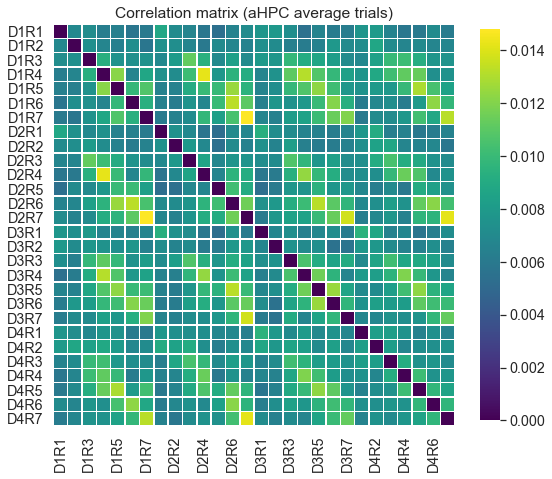

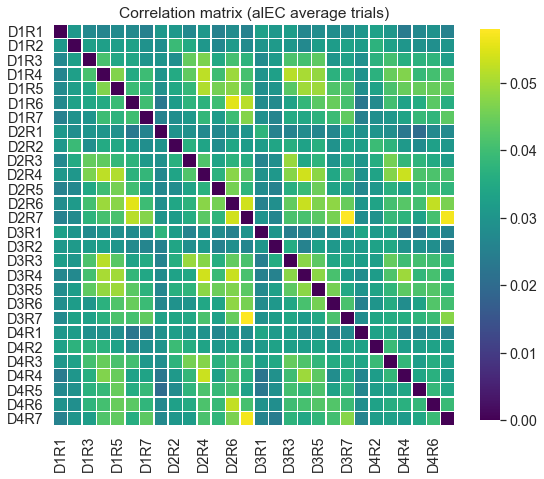

In [28]:
# reset diagnol values to 0s for more visability in the heatmap
np.fill_diagonal(aHPC_trial_corr.to_numpy(), 0)
np.fill_diagonal(alEC_trial_corr.to_numpy(), 0)
#print(aHPC_trial_corr.head())
#print(alEC_trial_corr.head())

# aHPC
sns.set(style="white", font_scale=1.3)
df = aHPC_trial_corr
mask = np.triu(np.ones_like(df, dtype=np.bool))
f, ax = plt.subplots(figsize=(9, 9))
ax.set_title("Correlation matrix (aHPC average trials)")
s = sns.heatmap(df, cmap= "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .8})
f.savefig(join(output_dir,"correlation_matrices/aHPC_lr/aHPC_trial_corr.png"), dpi=90)

# alEC
df = alEC_trial_corr
mask = np.triu(np.ones_like(df, dtype=np.bool))
f, ax = plt.subplots(figsize=(9, 9))
ax.set_title("Correlation matrix (alEC average trials)")
s = sns.heatmap(df, cmap= "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .8})
f.savefig(join(output_dir,"correlation_matrices/alEC_lr/alEC_trial_corr.png"), dpi=90)

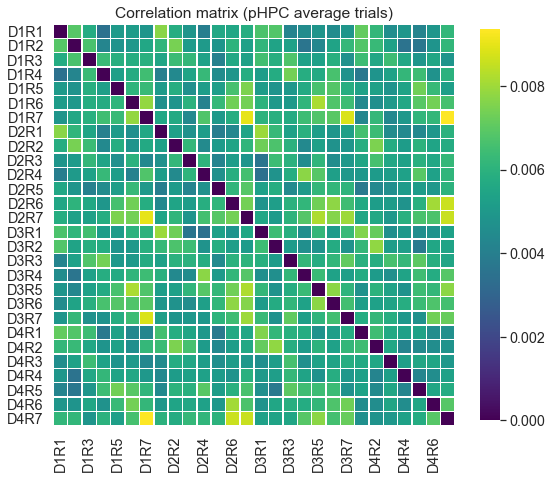

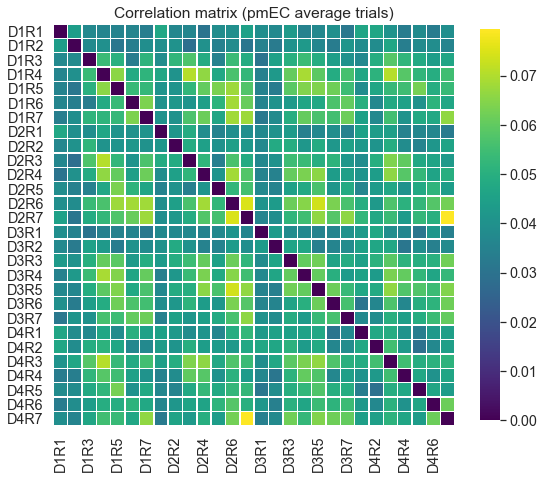

In [29]:
#TODO: re-write more efficiently

# reset diagnol values to 0s for more visability in the heatmap
np.fill_diagonal(pHPC_trial_corr.to_numpy(), 0)
np.fill_diagonal(pmEC_trial_corr.to_numpy(), 0)
#print(pHPC_trial_corr.head())
#print(pmEC_trial_corr.head())

# pHPC
sns.set(style="white", font_scale=1.3)
df = pHPC_trial_corr
mask = np.triu(np.ones_like(df, dtype=np.bool))
f, ax = plt.subplots(figsize=(9, 9))
ax.set_title("Correlation matrix (pHPC average trials)")
s = sns.heatmap(df, cmap= "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .8})
f.savefig(join(output_dir,"correlation_matrices/pHPC_lr/pHPC_trial_corr.png"), dpi=90)

# pmEC
df = pmEC_trial_corr
mask = np.triu(np.ones_like(df, dtype=np.bool))
f, ax = plt.subplots(figsize=(9, 9))
ax.set_title("Correlation matrix (pmEC average trials)")
s = sns.heatmap(df, cmap= "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .8})
f.savefig(join(output_dir,"correlation_matrices/pmEC_lr/pmEC_trial_corr.png"), dpi=90)

##  Model-based RSA1
a model for comparing inter-voxel similarity for within and across days

### Initializing the prediction matrix

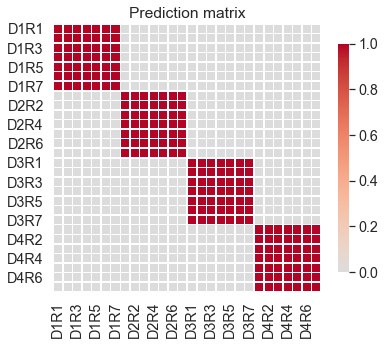

In [30]:
def prediction_matrix():
    pred_mat = np.zeros(28*28).reshape(28, 28)

    for i in range(0,28,7):
        pred_mat[i:i+7,i:i+7] = 1

    pred_df = pd.DataFrame(pred_mat, index=trials, columns=trials)
    return pred_df

pred_df = prediction_matrix()

f, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Prediction matrix")
s = sns.heatmap(pred_df, center= 0, cmap= "coolwarm", square=True, linewidths=.5, cbar_kws={"shrink": .7})

### Creating appropriate matrix inclusion masks per participant
The purpose of this step is to exclude any spurious correlation that might occur between consecutive trials (specific day, specific repetition). What we are after essentially is correlating voxels with voxels within a day and a repetition. However, what we don't want is to correlate consecutive trials, e.g., (DxR1 and DyR1) if we are within the same repetition cycle, or (DxR1 and DxR2) if we are starting a new repetition cycle. In those cases, we will exclude from our neural and prediction matrices the values that are located at the beginning of a consecutive trial. The location and order of the consecutive trials vary across participant. Hence, we apply the below participant-specific treatment to extract the appropriate indices from the neural and prediction matrix for the given participant.  

**The rationale for this treatment that we are applying here is as follows:**
1. Start with a 28x28 (total number of trials) set to all 1s matrix.
2. Exclude the values of lower triangle and diagonal (by setting them to 0).
3. Exclude the values of consecutive trials for that participant (by setting them to 0). Where the resulting inclusion matrix is defined as:     
$ RSA inclusion Mask_p = Upper Triangle Above Diagnol - Consecutive Trials_p $
4. Flatten the resulting inclusion matrix into a 1D vector.
5. Get the indices of values that are equal to 1 in the vector, and save them separately per participant/ROI.
6. In the next step, after flattening the neural and prediction matrix for a given participant and ROI, only extract the values given by the indices that were calculated in this step.

Let's look at P064 for example, we want to exclude the value from its 28x28 correlation matrix that is located under `(D2R1, D3R1)` because that value is located at the beginning of a consecutive trial (highlighted below). We add a new column called _new_trial_ that is set to 0 if we are within the same trial, and an integer otherwise.

In [31]:
logs['P064']['new_trial'] = logs['P064']['virtual_day'].diff().fillna(0) # add a new column to indicate new trials
df = logs['P064']

def highlight_col(x):
    #copy df to new - original data are not changed
    df = x.copy()
    #set by condition
    mask = df['new_trial'] != 0
    df.loc[mask, :] = 'background-color: yellow'
    df.loc[~mask,:] = 'background-color: ""'
    return df    

df.head(23).style.apply(highlight_col, axis=None)

,fc_on,fc_off,cue_start,cue_id,blkscrn_on,volume,repetition,real_time,virtual_day,trial_endtime,new_trial
0,20793,24266,24266,8.330000,25782,12,1,3.464900,2,25782,0.000000
1,25782,30182,30204,13.000000,31705,14,1,9.375000,2,31705,0.000000
2,31705,33715,33716,10.040000,35232,16,1,12.901000,2,35232,0.000000
3,35232,39565,39587,18.000000,41098,19,1,18.750000,2,41098,0.000000
4,41098,51014,51015,12.500000,52531,24,1,30.208800,2,52531,0.000000
5,52531,56764,56786,20.000000,58297,26,1,35.937500,2,58297,0.000000
6,58297,61463,61464,14.300000,62980,28,1,40.660900,2,62980,0.000000
7,62980,75496,75518,14.000000,77029,34,1,54.687500,2,77029,0.000000
8,77029,87195,87196,18.370000,88712,40,1,66.379300,2,88712,0.000000
9,88712,91128,91151,19.000000,92661,41,1,70.312500,2,92662,0.000000


If we combine all the highlighted rows, we get the below dataframe. From the `virtual_day` and `repetition` columns, we can constuct the columns to be excluded from the neural matrix later.

In [32]:
logs['P064'][logs['P064']['new_trial'] != 0]

,fc_on,fc_off,cue_start,cue_id,blkscrn_on,volume,repetition,real_time,virtual_day,trial_endtime,new_trial
11,99761,104511,104511,6.53,106027,47,1,83.6989,3,106027,1.0
22,175140,183856,183856,8.29,185372,82,1,163.0485,1,185372,-2.0
33,259851,263834,263834,6.43,265351,117,1,243.0130,4,265351,3.0
44,369778,375244,375244,7.04,376761,166,2,354.4505,3,376761,-1.0
55,443773,453373,453373,8.25,454889,201,2,432.5661,1,454889,-2.0
66,524019,537917,537918,9.08,539434,238,2,517.1238,2,539434,1.0
77,610030,613780,613780,6.43,615296,272,2,592.9611,4,615296,2.0
88,718407,722856,722857,8.20,724373,320,3,702.0314,1,724373,-3.0
99,798985,804151,804152,6.48,805668,355,3,783.3453,4,805668,3.0
110,879014,884980,884980,7.00,886496,391,3,864.1635,3,886496,-1.0


In [33]:
consec_trials = {p:0 for p in participants}
    
for p in participants:
    logs[p]['new_trial'] = logs[p]['virtual_day'].diff().fillna(0) # add a new column to indicate new trials
    
    ct_rows = [] # rows of consecutive trials 
    ct_cols = [] # columns of consecutive trials

    # rows_2exclude
    rows_2exclude = logs[p][logs[p]['new_trial'] != 0].index-1
    #print(rows_2exclude)
    for r in rows_2exclude:
        day_r = logs[p].loc[r,'virtual_day']
        rep_r = logs[p].loc[r,'repetition']
        row_2ex = ('D%dR%d' %(day_r,rep_r))
        #print(row_2ex)
        ct_rows.append(row_2ex)

    # cols_2exclude
    cols_2exclude = logs[p][logs[p]['new_trial'] != 0].index
    #print(cols_2exclude)
    for c in cols_2exclude:
        day_c = logs[p].loc[c,'virtual_day']
        rep_c = logs[p].loc[c,'repetition']
        col_2ex = ('D%dR%d' %(day_c,rep_c))
        #print(col_2ex)
        ct_cols.append(col_2ex)

    #print(ct_rows)
    #print(ct_cols)
    ls1 = list(zip(ct_cols, ct_rows))
    ls2 = list(zip(ct_rows, ct_cols))
    consec_trials[p] = ls1 + ls2
    #consec_trials[p] = list(zip(ct_rows, ct_cols))

#consec_trials['P064']

Let's first visualize the steps that we are taking for one participant (P064), and then we will apply them for all.

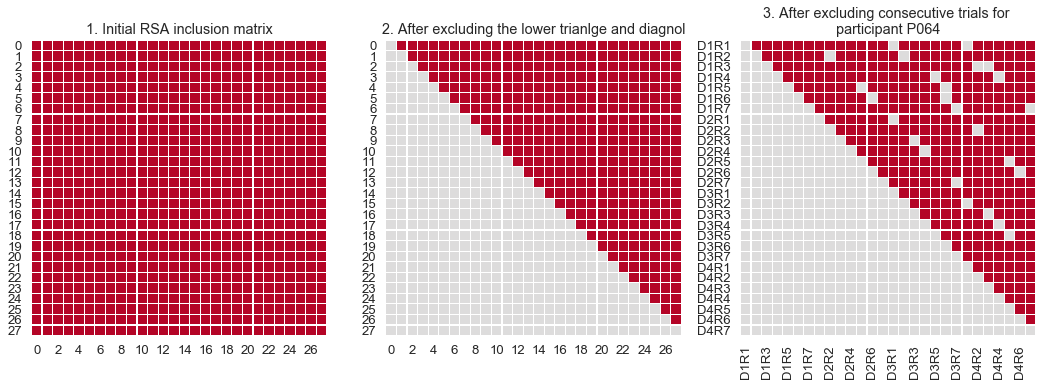

Indices of the values highlighted in red in the 3rd matrix after flattening it:
[  1   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  18  19
  20  22  23  24  25  26  27  30  31  32  33  34  35  37  38  39  40  41
  42  44  45  46  47  48  49  50  51  52  53  54  55  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  80  81  82  83
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 103 104 105 106
 107 109 110 111 117 118 119 120 121 122 124 125 126 127 128 129 130 132
 133 134 135 136 137 138 139 146 147 148 149 150 151 153 154 155 156 157
 158 160 161 162 163 164 165 166 167 175 176 177 178 179 180 181 182 183
 184 185 186 187 189 190 191 192 193 194 204 205 206 207 208 209 211 212
 213 214 215 216 217 218 219 220 221 222 223 233 234 235 236 237 238 239
 240 241 242 243 244 245 247 248 249 250 251 262 263 264 265 266 267 269
 270 271 272 273 274 275 276 277 278 279 291 292 293 294 295 296 298 299
 300 301 302 303 304 305 306 307 320 321 322

In [34]:
sns.set(style="white",font_scale=1.2)
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 19))
im = np.ones(28*28).reshape(28,28) # all 1s matrix

ax[0].set_title("1. Initial RSA inclusion matrix")
ax[0] = sns.heatmap(im, center=0, cmap="coolwarm", square=True, linewidths=.1, cbar=False, ax=ax[0])

im = np.triu(im, k=1) # exclude lower triangle and diagnol
ax[1].set_title("2. After excluding the lower trianlge and diagnol")
ax[1] = sns.heatmap(im, center=0, cmap="coolwarm", square=True, linewidths=.1, cbar=False, ax=ax[1])


im_df = pd.DataFrame(im, columns=trials, index=trials)
for ct in consec_trials['P064']:
    im_df.loc[ct[0],ct[1]] = 0
ax[2].set_title("3. After excluding consecutive trials for \nparticipant P064")
ax[2] = sns.heatmap(im_df, center=0, cmap="coolwarm", square=True, linewidths=.1, cbar=False, ax=ax[2])
plt.show()

vech = im_df.to_numpy().flatten()
print("Indices of the values highlighted in red in the 3rd matrix after flattening it:")
print((np.where(vech==1)[0]))

Now, we will apply the above steps to all 27 participants.

In [35]:
# TODO: Plot all mask matrices for participants next to each other!

rsa_inclusion_masks = {p:0 for p in participants}

for p in participants:
    #print(p)

    im = np.ones(28*28).reshape(28,28) # all 1s matrix
    im = np.triu(im, k=1) # exclude lower triangle and diagnol
    im_df = pd.DataFrame(im, columns=trials, index=trials)
    for ct in consec_trials[p]:
        im_df.loc[ct[0],ct[1]] = 0

    #plt.matshow(im_df)
    #sns.heatmap(im_df, center=0, cmap="coolwarm", square=True, cbar=False)


    vech = im_df.to_numpy().flatten()
    rsa_inclusion_masks[p] = (np.where(vech==1)[0])
    
#rsa_inclusion_masks

### Running the model
A model for comparing inter-voxel similarity for within and across days

In [36]:
# define run_RSA_glm function
# What it does:
# vectorizes both prediction matrix and neural matrices per participant, removes same rep different days values,
# runs a linear model and saves the t-values

t_values = {}

def run_RSA_glm():

    for i_roi in rois_mni:
        print("\n", i_roi)
        t_values.update({i_roi: []})
        
        #for k,v in list(trialbytrial_all[i_roi].items())[3:5]:        
        #for p,trial_cor in trialbytrial_all[i_roi].items():
        for p in participants:
            
            # prediction similarity matrix
            pcor =  prediction_matrix() # this is the 28x28 prediction matrix
            vech_pred = pcor.to_numpy().flatten() # vectorize matrix to 1D
            #pred_sim = np.delete(vech_pred, rsa_inclusion_masks[p]) # customize it to every participant
            pred_sim = vech_pred[rsa_inclusion_masks[p]] # customize it to every participant
            #print(pred_sim.shape)
            #print(rsa_inclusion_masks[p].shape)
            
            # neural similarity matrix
            tcor = trialbytrial_all[i_roi][p] # this is the 28x28 matrix for participant p
            #print(tcor.shape)
            vech_neural = tcor.to_numpy().flatten() # vectorize matrix to 1D
            #neural_sim = np.delete(vech_neural, rsa_inclusion_masks[p]) # exclude irrelevant values
            neural_sim = vech_neural[rsa_inclusion_masks[p]] # exclude irrelevant values
            #print(neural_sim.shape)
            
            # combine neural and pred into one dataframe to run the linear model
            rsa_df = pd.DataFrame({'neural_sim':neural_sim, 'pred_sim':pred_sim})

            # linear model
            model = smf.glm(formula = 'neural_sim~pred_sim', data=rsa_df)
            result = model.fit()
            #print(result.summary())
            #print('T-values: ', result.tvalues)
            t_values[i_roi].append(result.tvalues[1])
            
    return pd.DataFrame.from_dict(t_values)
            
tvalues_df = run_RSA_glm()


 aHPC

 alEC

 pHPC

 pmEC


### Model outcomes

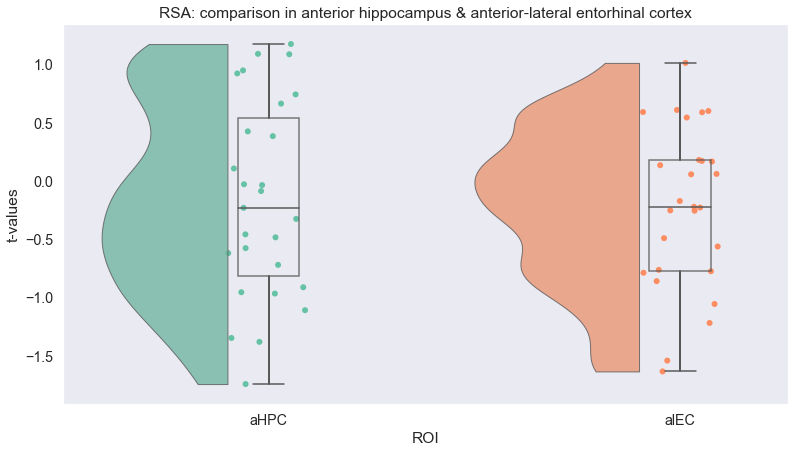

In [37]:
tvalues_melt = pd.melt(tvalues_df, value_vars=["aHPC", "alEC"], var_name="ROI", value_name="t-values")

sns.set(style="dark",font_scale=1.3)
#same thing with a single command: now x **must** be the categorical value
dx = "ROI"; dy = "t-values"; ort = "v"; pal = "Set2"; sigma = 0.3
f, ax = plt.subplots(figsize=(13, 7))

ax = pt.RainCloud(x = dx, y = dy, data = tvalues_melt, palette = pal, bw = sigma, offset = 0.1,
                  width_viol = .8, ax = ax, orient = ort, point_size = 6, alpha=0.8)

ax = plt.title("RSA: comparison in anterior hippocampus & anterior-lateral entorhinal cortex")

#### One-Sample T-Test

In [38]:
# Run one-sample t-test per ROI
print('aHPC', stats.ttest_1samp(tvalues_df['aHPC'], 0))
print('alEC', stats.ttest_1samp(tvalues_df['alEC'], 0))

aHPC Ttest_1sampResult(statistic=-1.0018028902181288, pvalue=0.3256718133975973)
alEC Ttest_1sampResult(statistic=-1.6868154895103167, pvalue=0.1036028568099064)


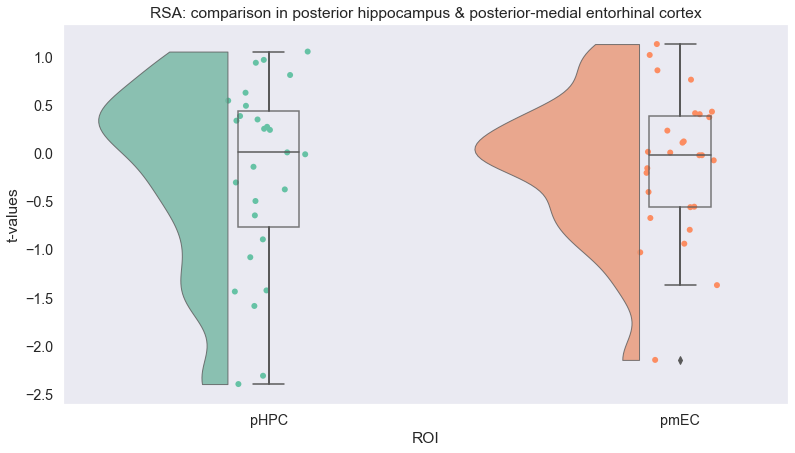

In [39]:
# New ROIs
tvalues_melt = pd.melt(tvalues_df, value_vars=["pHPC", "pmEC"], var_name="ROI", value_name="t-values")

sns.set(style="dark",font_scale=1.3)
#same thing with a single command: now x **must** be the categorical value
dx = "ROI"; dy = "t-values"; ort = "v"; pal = "Set2"; sigma = 0.3
f, ax = plt.subplots(figsize=(13, 7))

ax = pt.RainCloud(x = dx, y = dy, data = tvalues_melt, palette = pal, bw = sigma, offset = 0.1,
                  width_viol = .8, ax = ax, orient = ort, point_size = 6, alpha=0.8)

ax = plt.title("RSA: comparison in posterior hippocampus & posterior-medial entorhinal cortex")

In [40]:
# Run one-sample t-test per ROI

print('pHPC', stats.ttest_1samp(tvalues_df['pHPC'], 0))
print('pmEC', stats.ttest_1samp(tvalues_df['pmEC'], 0))

pHPC Ttest_1sampResult(statistic=-1.1591562656401584, pvalue=0.2569279780068967)
pmEC Ttest_1sampResult(statistic=-0.798055891370385, pvalue=0.43206722382801666)


## Model-based RSA : Statistical comparison of learning stages
inter-voxel similarity model 

- Take the average of the correlations for comparisons of the first three repetitions (R1 vs. R2, R1 vs. R3, R2 vs. R3) and the last three repetitions (R5 vs. R6, R5 vs. R7, R6 vs. R7) for each participant.
- Separately for same day vs. different days.
- This could give us a good statistical comparison of what happens early (first repetitions) and late (last repetitions) in learning.

### Preparing the data

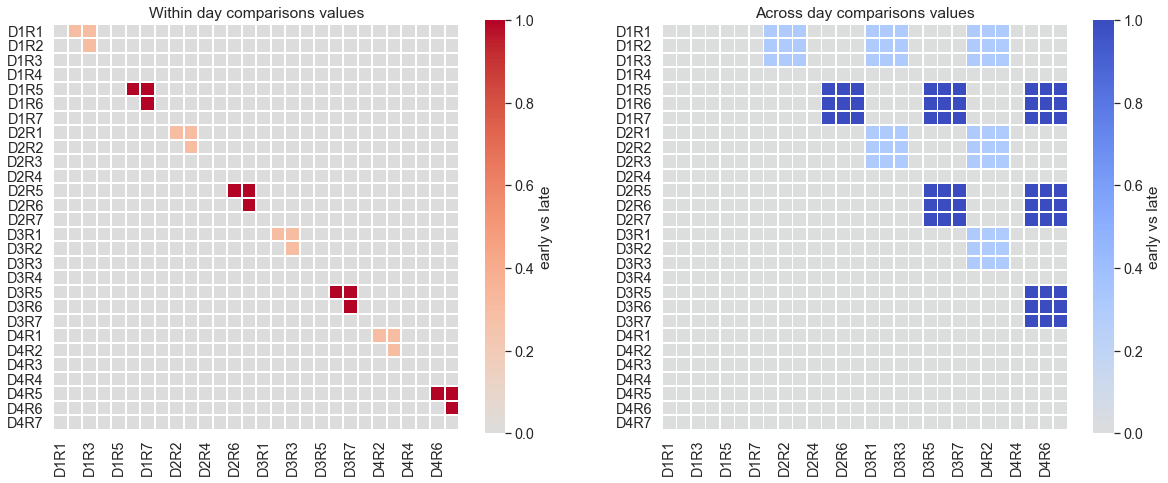

In [41]:

# same days comparisons
trial_demo = pd.DataFrame(np.zeros(28*28).reshape(28,28), columns=trials, index=trials)
for d in ['D1', 'D2', 'D3', 'D4']:
    #print(d)
    for early_r in list(combinations(['%sR1'%d,'%sR2'%d,'%sR3'%d],2)):
        trial_demo.loc[early_r[0], early_r[1]] = 0.3
    for late_r in list(combinations(['%sR5'%d,'%sR6'%d,'%sR7'%d],2)):
        trial_demo.loc[late_r[0], late_r[1]] = 1

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 19))
ax[0] = sns.heatmap(trial_demo, center= 0, cmap= "coolwarm", square=True, linewidths=.8, ax=ax[0],
                    cbar_kws={"shrink": .4,'label': 'early vs late'})
ax[0] = ax[0].set_title('Within day comparisons values')

# different days comparisons
trial_demo = pd.DataFrame(np.zeros(28*28).reshape(28,28), columns=trials, index=trials)
for d in list(combinations(['D1', 'D2', 'D3', 'D4'], 2)):
    for early_r1 in ['R1', 'R2', 'R3']:
        for early_r2 in ['R1', 'R2', 'R3']:
            trial_demo.loc[d[0]+early_r1, d[1]+early_r2] = 0.3
    for late_r1 in ['R5', 'R6', 'R7']:
        for late_r2 in ['R5', 'R6', 'R7']:
            trial_demo.loc[d[0]+late_r1, d[1]+late_r2] = 1
            
ax[1] = sns.heatmap(trial_demo, center= 0, cmap= "coolwarm_r", square=True, linewidths=.8, ax=ax[1],
                    cbar_kws={"shrink": .4,'label': 'early vs late'})
ax[1] = ax[1].set_title('Across day comparisons values')

Next, we will apply those masks on all 27 participants' correlation matrices for all ROIs to generate calculated averages of inter-voxel similarity correlations for early vs late learning stages.

### Running the model

In [42]:
# define inter-voxel similarity model function
# What it does:

def run_rsa_learning_model(roi):
    early_reps = []; late_reps = []
    df1 = pd.DataFrame({'sub_id':participants, 'ROI':roi, 'early':0, 'late':0})
    df2 = pd.DataFrame({'sub_id':participants, 'ROI':roi, 'early':0, 'late':0})

    for p in participants:
        #print(p)
        trial_df = trialbytrial_all[roi][p]
        
        # same days comparisons
        for d in ['D1', 'D2', 'D3', 'D4']:
            #print(d)
            for early_r in list(combinations(['%sR1'%d,'%sR2'%d,'%sR3'%d],2)):
                #print(early_r[0], early_r[1])
                early_reps.append(trial_df.loc[early_r[0], early_r[1]])
            for late_r in list(combinations(['%sR5'%d,'%sR6'%d,'%sR7'%d],2)):
                #print(late_r[0], late_r[1])
                late_reps.append(trial_df.loc[late_r[0], late_r[1]])

        #print(early_reps)
        df1.loc[(df1['sub_id'] == p),'early'] = np.mean(early_reps)
        df1.loc[(df1['sub_id'] == p),'late']  = np.mean(late_reps)
        early_reps = []; late_reps = []
        
        # different days comparisons
        for d in list(combinations(['D1', 'D2', 'D3', 'D4'], 2)):
            for early_r1 in ['R1', 'R2', 'R3']:
                for early_r2 in ['R1', 'R2', 'R3']:
                    #print(d[0]+early_r1, d[1]+early_r2)
                    #print(trial.loc[d[0]+early_r1, d[1]+early_r2])
                    early_reps.append(trial_df.loc[ d[0]+early_r1, d[1]+early_r2 ])
            for late_r1 in ['R5', 'R6', 'R7']:
                for late_r2 in ['R5', 'R6', 'R7']:
                    #print(d[0]+late_r1, d[1]+late_r2)
                    #print(trial.loc[d[0]+late_r1, d[1]+late_r2])
                    late_reps.append(trial_df.loc[ d[0]+late_r1, d[1]+late_r2 ])

        #print(len(late_reps))
        df2.loc[(df2['sub_id'] == p),'early'] = np.mean(early_reps)
        df2.loc[(df2['sub_id'] == p),'late']  = np.mean(late_reps)
        early_reps = []; late_reps = []
    
    df1['daytype'] = "within-day"
    df2['daytype'] = "across-day"
    return df1.append(df2, ignore_index=True)

Run the model for anterior hippocampus.

In [43]:
ivsim_ahpc = run_rsa_learning_model('aHPC')

print(ivsim_ahpc.head())
ivsim_ahpc.tail()

  sub_id   ROI     early      late     daytype
0   P031  aHPC  0.003774  0.005791  within-day
1   P032  aHPC  0.005021  0.009376  within-day
2   P033  aHPC  0.010106  0.011836  within-day
3   P034  aHPC  0.005201  0.005988  within-day
4   P035  aHPC  0.005694  0.004771  within-day


,sub_id,ROI,early,late,daytype
49,P072,aHPC,0.014010,0.031758,across-day
50,P073,aHPC,0.020998,0.018246,across-day
51,P074,aHPC,0.005189,0.013611,across-day
52,P075,aHPC,0.007092,0.009882,across-day
53,P076,aHPC,0.006860,0.011198,across-day


Run the model for  region.

In [44]:
ivsim_alec = run_rsa_learning_model('alEC')

print(ivsim_alec.head())
ivsim_alec.tail()

  sub_id   ROI     early      late     daytype
0   P031  alEC  0.015272  0.017814  within-day
1   P032  alEC  0.010654  0.026608  within-day
2   P033  alEC  0.047322  0.058766  within-day
3   P034  alEC  0.068364  0.063082  within-day
4   P035  alEC  0.030673  0.040259  within-day


,sub_id,ROI,early,late,daytype
49,P072,alEC,0.066714,0.105440,across-day
50,P073,alEC,0.057087,0.056248,across-day
51,P074,alEC,0.010506,0.024151,across-day
52,P075,alEC,0.021055,0.032224,across-day
53,P076,alEC,0.029418,0.035096,across-day


In [45]:
# NEW ROIs..

In [46]:
ivsim_phpc = run_rsa_learning_model('pHPC')

print(ivsim_phpc.head())
ivsim_phpc.tail()

  sub_id   ROI     early      late     daytype
0   P031  pHPC  0.004569  0.005206  within-day
1   P032  pHPC  0.003969  0.005153  within-day
2   P033  pHPC  0.008862  0.009274  within-day
3   P034  pHPC  0.004965  0.004674  within-day
4   P035  pHPC  0.005337  0.004592  within-day


,sub_id,ROI,early,late,daytype
49,P072,pHPC,0.012483,0.019111,across-day
50,P073,pHPC,0.007830,0.005171,across-day
51,P074,pHPC,0.005040,0.009478,across-day
52,P075,pHPC,0.006760,0.008667,across-day
53,P076,pHPC,0.004216,0.006403,across-day


In [47]:
ivsim_pmec = run_rsa_learning_model('pmEC')

print(ivsim_pmec.head())
ivsim_pmec.tail()

  sub_id   ROI     early      late     daytype
0   P031  pmEC  0.038895  0.044735  within-day
1   P032  pmEC  0.018754  0.017302  within-day
2   P033  pmEC  0.058438  0.066553  within-day
3   P034  pmEC  0.027279  0.019631  within-day
4   P035  pmEC  0.033657  0.028893  within-day


,sub_id,ROI,early,late,daytype
49,P072,pmEC,0.071565,0.128546,across-day
50,P073,pmEC,0.128213,0.078888,across-day
51,P074,pmEC,0.092859,0.110516,across-day
52,P075,pmEC,0.045704,0.064922,across-day
53,P076,pmEC,0.040259,0.056835,across-day


### Anterior Hippocampus Paired Sample T-Tests: Within and Across day Comparisons

  sub_id   ROI     daytype   time     value
0   P031  aHPC  within-day  early  0.003774
1   P032  aHPC  within-day  early  0.005021
2   P033  aHPC  within-day  early  0.010106
3   P034  aHPC  within-day  early  0.005201
4   P035  aHPC  within-day  early  0.005694


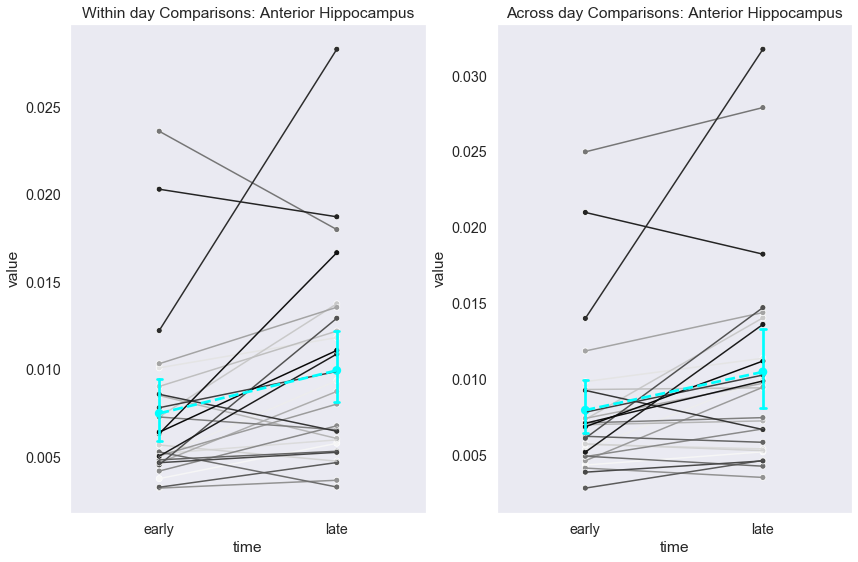

In [48]:
m = pd.melt(ivsim_ahpc, id_vars=["sub_id","ROI", "daytype"], value_vars=["early", "late"],
            var_name="time", value_name="value")
mdf = m[m['daytype'] == 'within-day']
print(mdf.head())

sns.set(style="dark",font_scale=1.3)
fig, ax = plt.subplots(1, 2, figsize=(14,9))
ax[0] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[0])
ax[0] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[0])
ax[0] = sns.pointplot(x="time", y="value", data=mdf, color='cyan', capsize=.03,
                      linestyles=['--'], ax=ax[0])
ax[0].set_title("Within day Comparisons: Anterior Hippocampus")


mdf = m[m['daytype'] == 'across-day']
ax[1] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[1])
ax[1] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[1])
ax[1] = sns.pointplot(x="time", y="value", data=mdf, color='cyan', capsize=.03,
                      linestyles=['--'], ax=ax[1])
ax[1].set_title("Across day Comparisons: Anterior Hippocampus")
plt.show()

In [49]:
# define a new dataframe to save all ttests outcomes
ttests_wa = pd.DataFrame({'ROI':np.repeat(['aHPC','alEC','pHPC','pmEC'],2),
                          'daytype': ['within-day', 'across-day','within-day', 'across-day',
                                      'within-day', 'across-day','within-day', 'across-day'],
                         't-statistic':0, 'p-value':0})

def el_pairedttest(daydf, daytype):
    a = daydf['late']
    b = daydf['early']
    g = sns.kdeplot(a, shade=True)
    g = sns.kdeplot(b, shade=True)
    g = sns.kdeplot(a-b, shade=True)
    g = plt.title("%s Paired Sample T-Test" %daytype)
    plt.show()

    assert_that(stats.ttest_rel(a, b), equal_to(stats.ttest_1samp(a-b, 0)))
    return stats.ttest_rel(a, b)

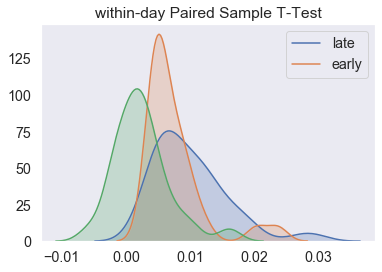

within-day (aHPC)
T-Statistic = 2.888655, P-Value = 0.007699


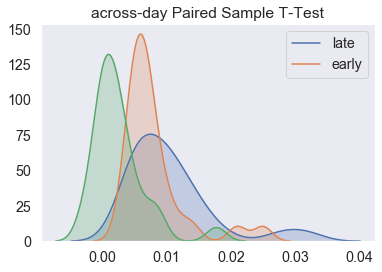

across-day (aHPC)
T-Statistic = 3.124446, P-Value = 0.004342


In [50]:
i_roi = 'aHPC'; df = ivsim_ahpc   
for dt in ['within-day', 'across-day']:
    daydf = df[df['daytype'] == dt]
    
    tStat, pValue = el_pairedttest(daydf, dt)
    
    print("%s (%s)" %(dt, i_roi))
    print("T-Statistic = %f, P-Value = %f" %(tStat, pValue)) #print the P-Value and the T-Statistic
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'t-statistic'] = tStat
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'p-value'] = pValue

### Anterior-lateral Entorhinal Cortex Paired Sample T-Tests: Within and Across day Comparisons

  sub_id   ROI     daytype   time     value
0   P031  alEC  within-day  early  0.015272
1   P032  alEC  within-day  early  0.010654
2   P033  alEC  within-day  early  0.047322
3   P034  alEC  within-day  early  0.068364
4   P035  alEC  within-day  early  0.030673


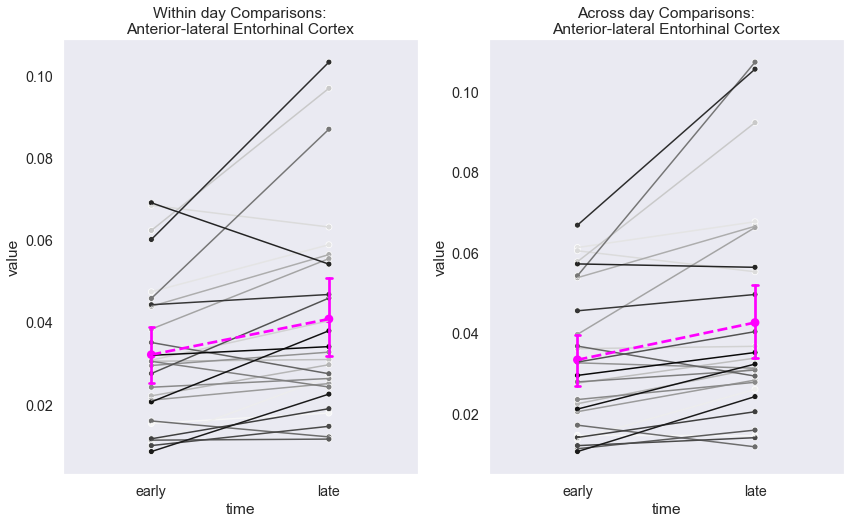

In [51]:
m = pd.melt(ivsim_alec, id_vars=["sub_id","ROI", "daytype"], value_vars=["early", "late"],
            var_name="time", value_name="value")
mdf = m[m['daytype'] == 'within-day']
print(mdf.head())

sns.set(style="dark",font_scale=1.3)
fig, ax = plt.subplots(1, 2, figsize=(14,8))

ax[0] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[0])
ax[0] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[0])
ax[0] = sns.pointplot(x="time", y="value", data=mdf, color='magenta', capsize=.03,
                      linestyles=['--'], ax=ax[0])
ax[0].set_title("Within day Comparisons:\nAnterior-lateral Entorhinal Cortex")


mdf = m[m['daytype'] == 'across-day']
ax[1] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[1])
ax[1] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[1])
ax[1] = sns.pointplot(x="time", y="value", data=mdf, color='magenta', capsize=.03,
                      linestyles=['--'], ax=ax[1])
ax[1].set_title("Across day Comparisons:\nAnterior-lateral Entorhinal Cortex")
plt.show()

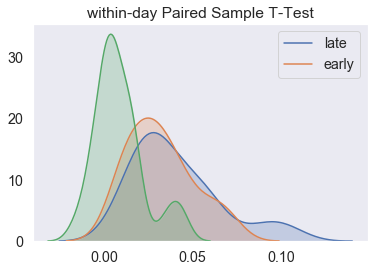

within-day (alEC)
T-Statistic = 3.239968, P-Value = 0.003262


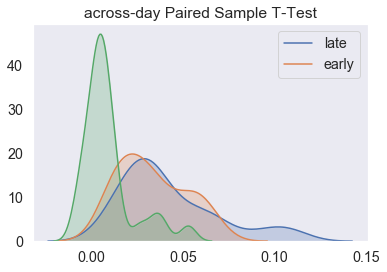

across-day (alEC)
T-Statistic = 3.445407, P-Value = 0.001948


In [52]:
i_roi = 'alEC'; df = ivsim_alec
for dt in ['within-day', 'across-day']:
    daydf = df[df['daytype'] == dt]
    tStat, pValue = el_pairedttest(daydf, dt)
    print("%s (%s)" %(dt, i_roi))
    print("T-Statistic = %f, P-Value = %f" %(tStat, pValue)) #print the P-Value and the T-Statistic
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'t-statistic'] = tStat
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'p-value'] = pValue

### New ROIs

  sub_id   ROI     daytype   time     value
0   P031  pHPC  within-day  early  0.004569
1   P032  pHPC  within-day  early  0.003969
2   P033  pHPC  within-day  early  0.008862
3   P034  pHPC  within-day  early  0.004965
4   P035  pHPC  within-day  early  0.005337


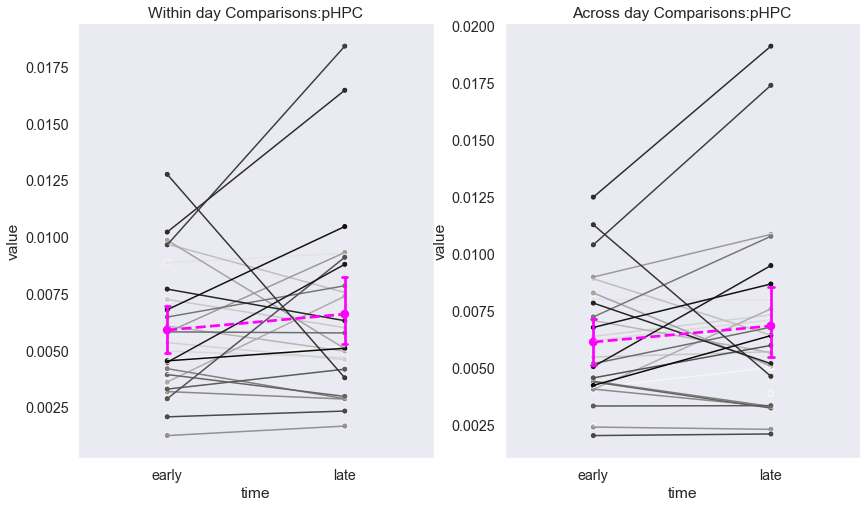

In [53]:
m = pd.melt(ivsim_phpc, id_vars=["sub_id","ROI", "daytype"], value_vars=["early", "late"],
            var_name="time", value_name="value")
mdf = m[m['daytype'] == 'within-day']
print(mdf.head())

sns.set(style="dark",font_scale=1.3)
fig, ax = plt.subplots(1, 2, figsize=(14,8))

ax[0] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[0])
ax[0] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[0])
ax[0] = sns.pointplot(x="time", y="value", data=mdf, color='magenta', capsize=.03,
                      linestyles=['--'], ax=ax[0])
ax[0].set_title("Within day Comparisons:pHPC")


mdf = m[m['daytype'] == 'across-day']
ax[1] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[1])
ax[1] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[1])
ax[1] = sns.pointplot(x="time", y="value", data=mdf, color='magenta', capsize=.03,
                      linestyles=['--'], ax=ax[1])
ax[1].set_title("Across day Comparisons:pHPC")
plt.show()

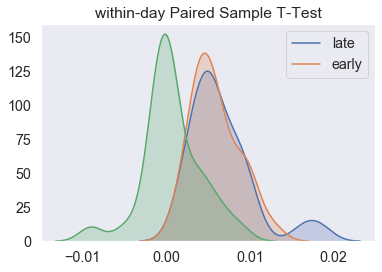

within-day (pHPC)
T-Statistic = 1.036628, P-Value = 0.309455


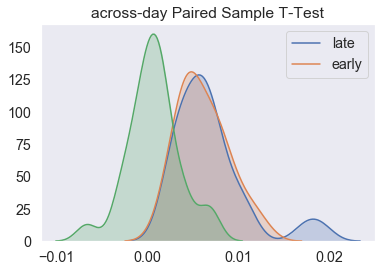

across-day (pHPC)
T-Statistic = 1.267876, P-Value = 0.216079


In [54]:
i_roi = 'pHPC'; df = ivsim_phpc
for dt in ['within-day', 'across-day']:
    daydf = df[df['daytype'] == dt]
    tStat, pValue = el_pairedttest(daydf, dt)
    print("%s (%s)" %(dt, i_roi))
    print("T-Statistic = %f, P-Value = %f" %(tStat, pValue)) #print the P-Value and the T-Statistic
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'t-statistic'] = tStat
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'p-value'] = pValue

  sub_id   ROI     daytype   time     value
0   P031  pmEC  within-day  early  0.038895
1   P032  pmEC  within-day  early  0.018754
2   P033  pmEC  within-day  early  0.058438
3   P034  pmEC  within-day  early  0.027279
4   P035  pmEC  within-day  early  0.033657


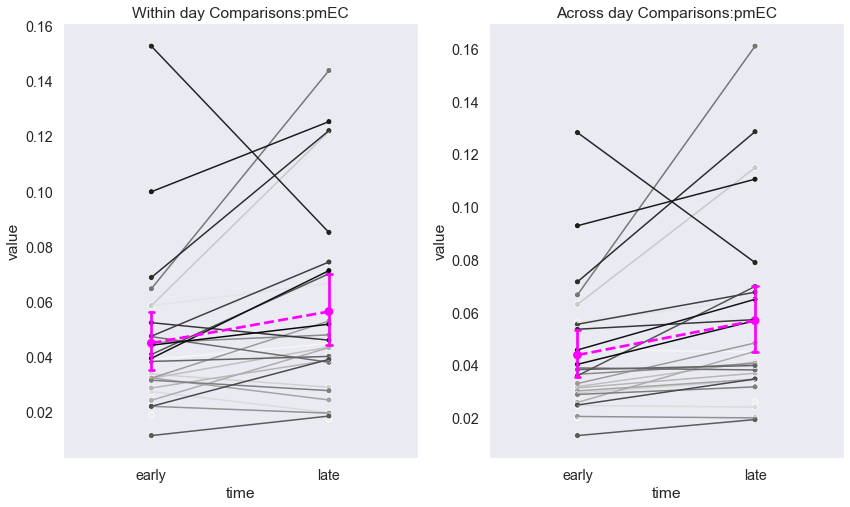

In [55]:
m = pd.melt(ivsim_pmec, id_vars=["sub_id","ROI", "daytype"], value_vars=["early", "late"],
            var_name="time", value_name="value")
mdf = m[m['daytype'] == 'within-day']
print(mdf.head())

sns.set(style="dark",font_scale=1.3)
fig, ax = plt.subplots(1, 2, figsize=(14,8))

ax[0] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[0])
ax[0] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[0])
ax[0] = sns.pointplot(x="time", y="value", data=mdf, color='magenta', capsize=.03,
                      linestyles=['--'], ax=ax[0])
ax[0].set_title("Within day Comparisons:pmEC")


mdf = m[m['daytype'] == 'across-day']
ax[1] = sns.lineplot(x="time", y="value", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r", ax=ax[1])
ax[1] = sns.scatterplot(x="time", y="value", hue='sub_id', data=mdf, legend=False, palette="gray_r",
                       ax=ax[1])
ax[1] = sns.pointplot(x="time", y="value", data=mdf, color='magenta', capsize=.03,
                      linestyles=['--'], ax=ax[1])
ax[1].set_title("Across day Comparisons:pmEC")
plt.show()

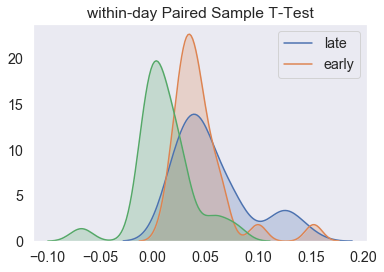

within-day (pmEC)
T-Statistic = 2.191365, P-Value = 0.037580


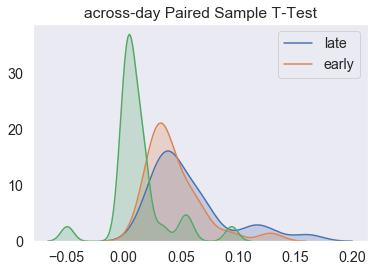

across-day (pmEC)
T-Statistic = 2.735510, P-Value = 0.011071


In [56]:
i_roi = 'pmEC'; df = ivsim_pmec
for dt in ['within-day', 'across-day']:
    daydf = df[df['daytype'] == dt]
    tStat, pValue = el_pairedttest(daydf, dt)
    print("%s (%s)" %(dt, i_roi))
    print("T-Statistic = %f, P-Value = %f" %(tStat, pValue)) #print the P-Value and the T-Statistic
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'t-statistic'] = tStat
    ttests_wa.loc[(ttests_wa['ROI'] == i_roi) & (ttests_wa['daytype'] == dt),'p-value'] = pValue

**All t-test values**

We started this analysis with 2 ROIs only (aHPC, and alEC), with a calculated alpha level of 0.05/4. Afterwards, we extended this analysis to include the later two ROIs (pHPC, and pmEC).

In [57]:
alpha = 0.05
alpha/4

0.0125

In [58]:
ttests_wa

,ROI,daytype,t-statistic,p-value
0,aHPC,within-day,2.888655,0.007699
1,aHPC,across-day,3.124446,0.004342
2,alEC,within-day,3.239968,0.003262
3,alEC,across-day,3.445407,0.001948
4,pHPC,within-day,1.036628,0.309455
5,pHPC,across-day,1.267876,0.216079
6,pmEC,within-day,2.191365,0.037580
7,pmEC,across-day,2.735510,0.011071


**Two-way ANOVA for Repeated Measures**    
The purpose of conducting this analysis is to assess if there is a significant difference between within-day and across-day inter-voxel similarity values. We apply this analysis for all ROIs.

ANOVA reveals a main effect of time, but we still don’t know if it comes from within or across day comparisons. Therefore, we ran the earlier t-tests and we conclude from them that the time effect is present in both day comparisons.

In [59]:
rois_dict = {'aHPC':ivsim_ahpc, 'alEC':ivsim_alec, 'pHPC':ivsim_phpc, 'pmEC':ivsim_pmec}

for i_roi, roi_df in rois_dict.items():
    #print(i_roi, roi_df)
    roi_melt = pd.melt(roi_df, id_vars=["sub_id","ROI", "daytype"], value_vars=["early", "late"],
            var_name="time", value_name="value")
    aovrm2way = AnovaRM(data=roi_melt, depvar='value', subject='sub_id', within=['time', 'daytype'])
    res2way = aovrm2way.fit()

    print(i_roi, res2way)

aHPC                   Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
time          9.9064 1.0000 26.0000 0.0041
daytype       3.0154 1.0000 26.0000 0.0943
time:daytype  0.0180 1.0000 26.0000 0.8942

alEC                   Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
time         11.7103 1.0000 26.0000 0.0021
daytype       2.9563 1.0000 26.0000 0.0974
time:daytype  0.2500 1.0000 26.0000 0.6212

pHPC                   Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
time          1.3662 1.0000 26.0000 0.2531
daytype       1.2138 1.0000 26.0000 0.2807
time:daytype  0.0004 1.0000 26.0000 0.9838

pmEC                   Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
time          6.1619 1.0000 26.0000 0.0198
daytype       0.0842 1.0000 26.0000 0.7740
time:daytype  0.9411 1.0000 26.0000 0.3409



### Link to behavioral data

In [60]:
behav_df = pd.DataFrame()

for filename in os.listdir(behv_dir+'corr'):
    if filename.endswith(".txt"):
        print(filename)
        df = pd.read_csv(join(behv_dir+'corr/',filename))
        behav_df = pd.concat([behav_df, df], axis=1)

sub_ids = []
for p in participants:
    sub_ids.append(int(p[-2:]))

behav_df = behav_df.loc[:,~behav_df.columns.duplicated()] # delete duplicate columns
behav_df =  behav_df[behav_df['sub_id'].isin(sub_ids)].reset_index(drop=True) # delete excluded subjects
behav_df.head()

virtem_timeline_lm_virtual_time_tvals.txt
virtem_timeline_mult-reg_virtual_time_tvals.txt
virtem_day_sorting_prct_correct.txt
virtem_timeline_average_error.txt


,sub_id,virtual_time,t_virtual_time,day_sorting_prct_correct,avg_error
0,31,59.925611,13.341292,100,0.259771
1,32,16.592822,5.290061,60,0.819244
2,33,19.837002,4.543258,100,1.007267
3,34,72.860058,16.025781,80,0.237742
4,35,15.488990,1.375274,100,1.058449


- the percentage of correctly sorted events from the day sorting task
- the average error from the timeline task
- how well virtual time predicted responses in the timeline task (t-values from a linear model)
- how well virtual time predicted responses in the timeline task when controlling for the effects of order and real time (t-values for virtual time from a linear model with multiple predictors)

In [61]:
#for i_roi, roi_df in rois_dict.items():  
def pearsonr_ivsim_behv(roi_df, daytype, c='royalblue'):    
    dfw = roi_df.loc[roi_df.daytype == daytype]
    i_roi = roi_df['ROI'][0]
    
    x = dfw['late'] - dfw['early']
    
    sns.set(style="dark",font_scale=1.3)
    fig = plt.figure(figsize=(14,10))
    fig.subplots_adjust(hspace=0.6, wspace=0.2)

    for i in range(1,5):
        y = behav_df.iloc[:,i]
        bm = behav_df.columns[i]

        plt.subplot(2, 2, i)
        plt.scatter(x,y, c=c)
        r = stats.pearsonr(x, y)[0]
        pv = stats.pearsonr(x, y)[1]
        plt.title(i_roi + " correlation #" + str(i) + ": " + daytype + "\nr =" + str(r) + "\npval= " + str(pv))
        plt.xlabel("increase in inter-voxel similarity")
        plt.ylabel(bm)
    
    #fig.savefig(join(behv_dir+'corr/'+i_roi + " corr: " + daytype + ".png"), dpi=90)

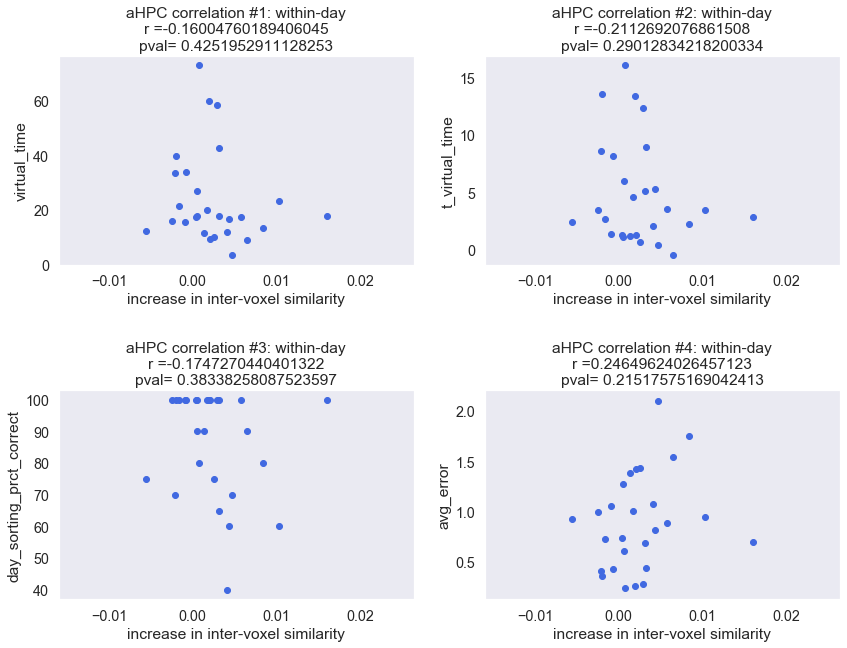

In [62]:
pearsonr_ivsim_behv(rois_dict['aHPC'], 'within-day')

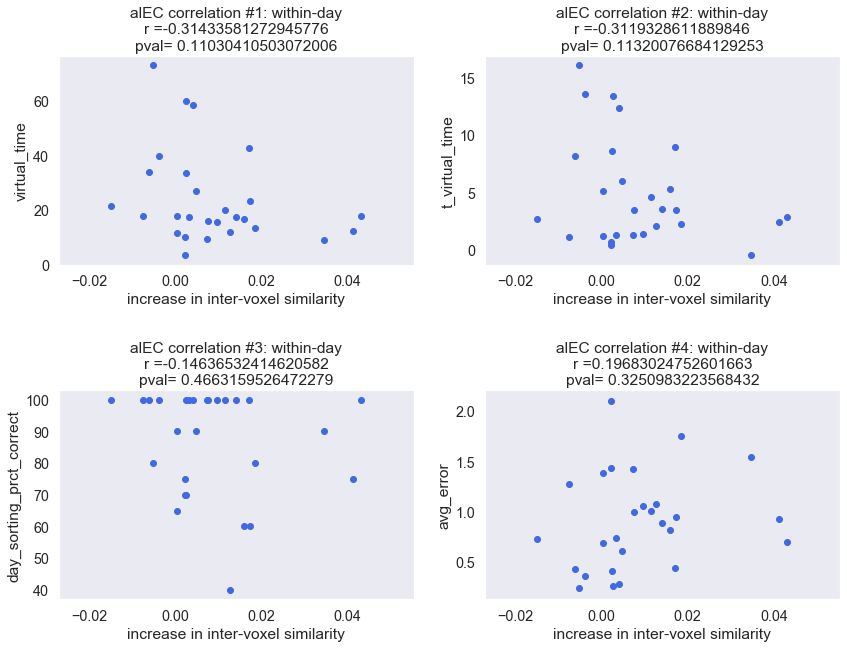

In [63]:
pearsonr_ivsim_behv(rois_dict['alEC'], 'within-day')

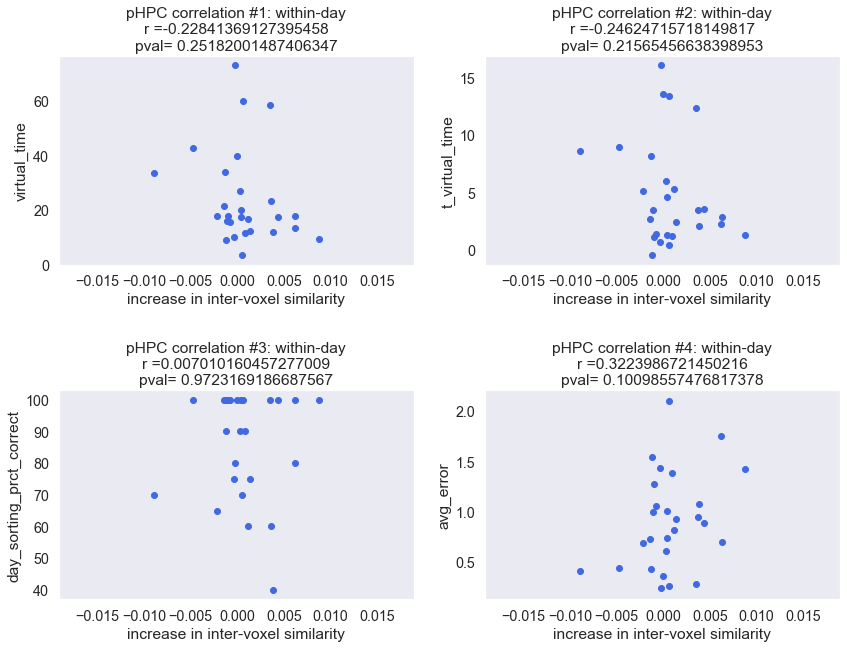

In [64]:
pearsonr_ivsim_behv(rois_dict['pHPC'], 'within-day')

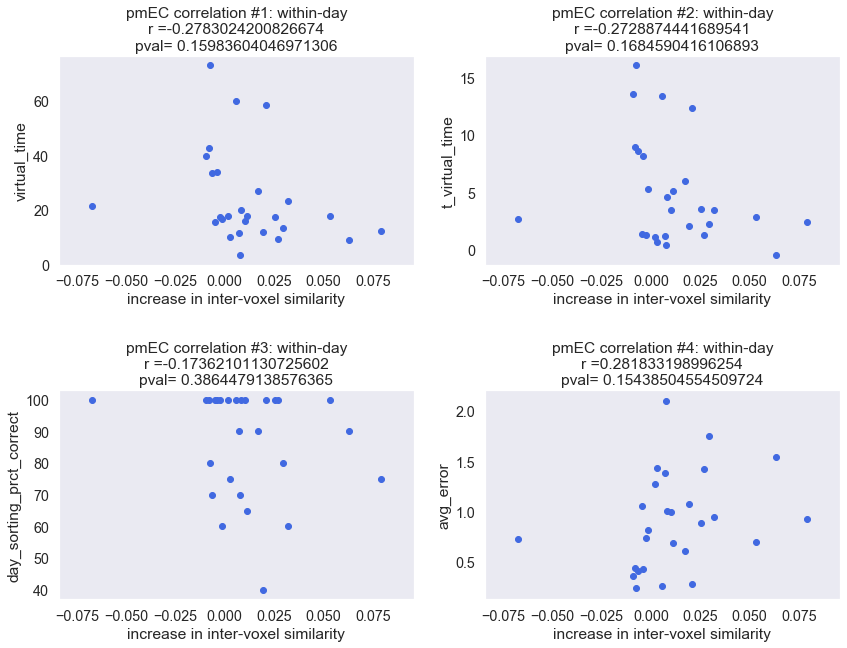

In [65]:
pearsonr_ivsim_behv(rois_dict['pmEC'], 'within-day')

**Across day**

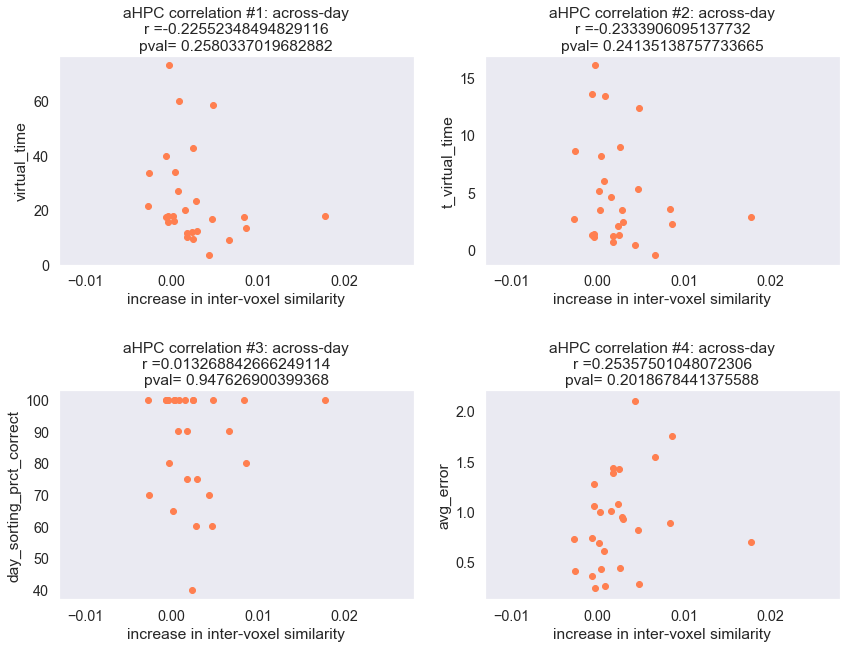

In [66]:
pearsonr_ivsim_behv(rois_dict['aHPC'], 'across-day', 'coral')

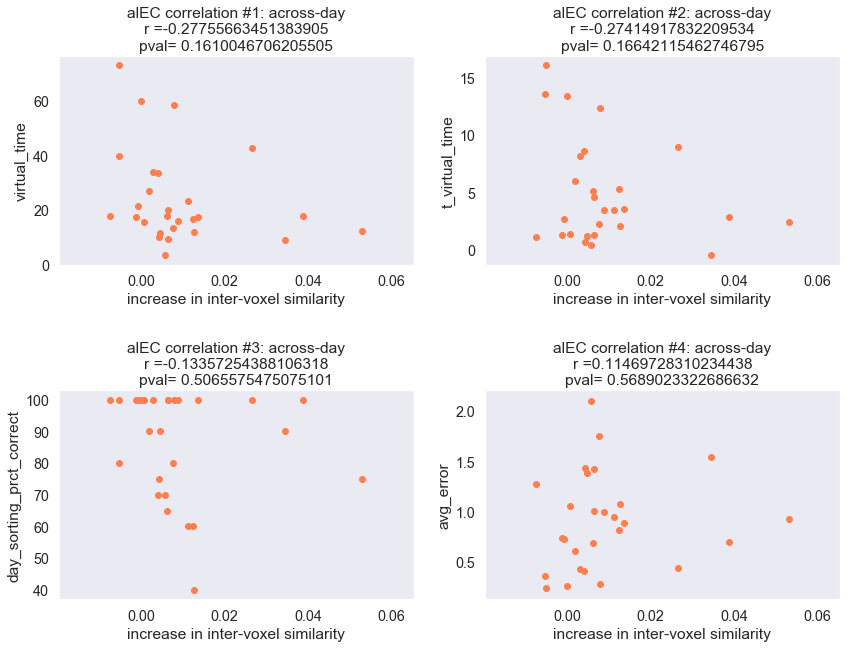

In [67]:
pearsonr_ivsim_behv(rois_dict['alEC'], 'across-day', 'coral')

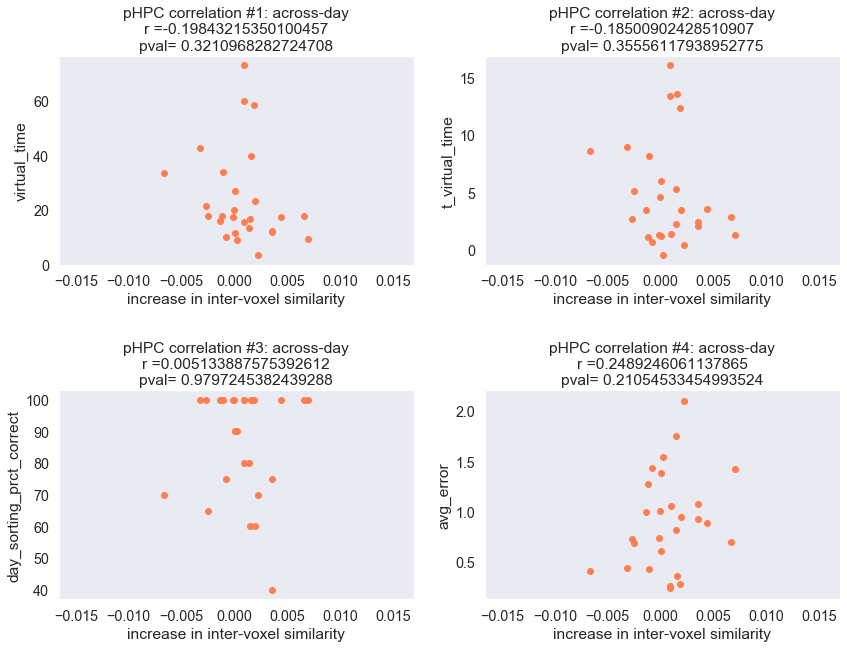

In [68]:
pearsonr_ivsim_behv(rois_dict['pHPC'], 'across-day', 'coral')

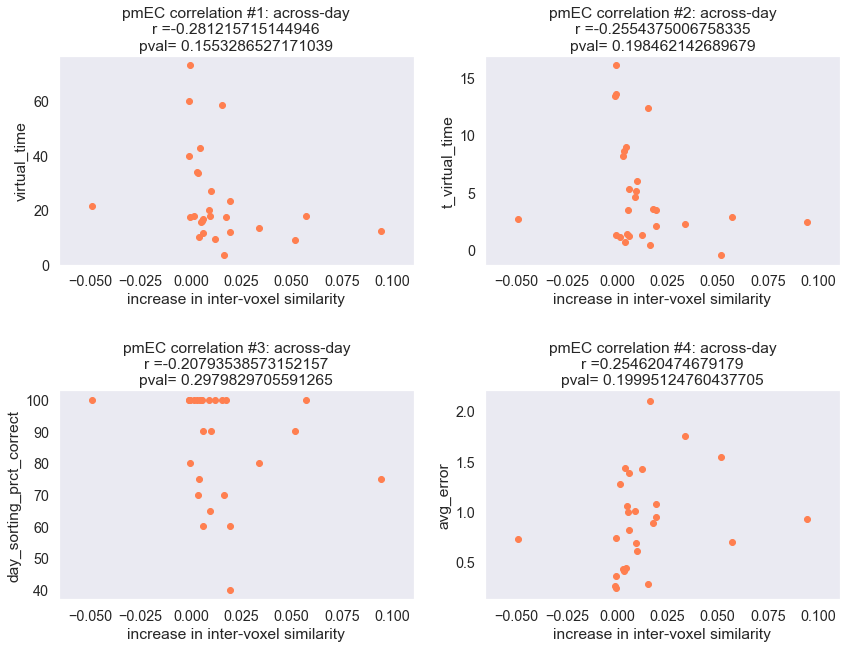

In [69]:
pearsonr_ivsim_behv(rois_dict['pmEC'], 'across-day', 'coral')

Additionally, you could test for a correlation between your conditions
- A: for each ROI, is there a correlation of the difference between late - early for within-day and between day?

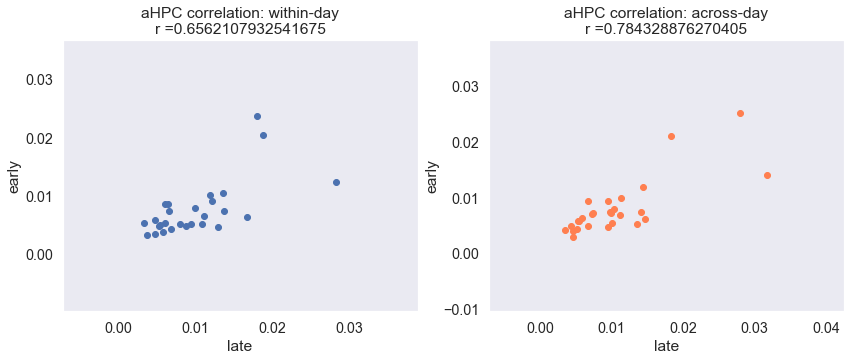

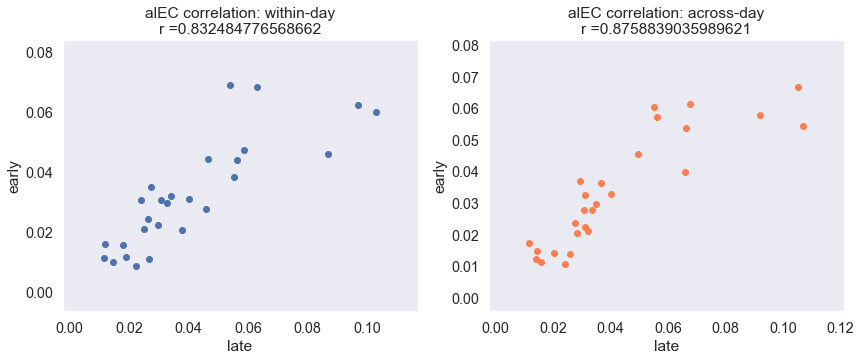

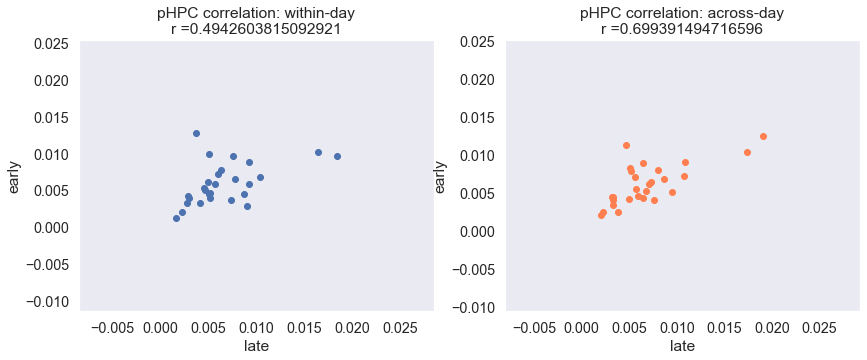

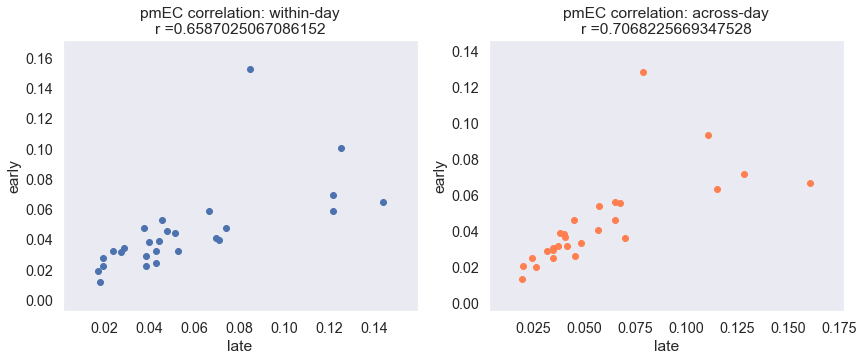

In [70]:
sns.set(style="dark",font_scale=1.3)

for i_roi, roi_df in rois_dict.items():
    fig = plt.figure(figsize=(14,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    dt = 'within-day'
    dfw = roi_df.loc[roi_df.daytype == dt]
    x = dfw['late']
    y = dfw['early']

    plt.subplot(1, 2, 1)
    plt.scatter(x,y)
    r = stats.pearsonr(x, y)[0]
    plt.title(i_roi + " correlation: " + dt + "\nr =" + str(r))
    plt.xlabel("late")
    plt.ylabel("early")
    
    dt = 'across-day'
    dfw = roi_df.loc[roi_df.daytype == dt]
    x = dfw['late']
    y = dfw['early']

    plt.subplot(1, 2, 2)
    plt.scatter(x,y, c='coral')
    r = stats.pearsonr(x, y)[0]
    plt.title(i_roi + " correlation: " + dt + "\nr =" + str(r))
    plt.xlabel("late")
    plt.ylabel("early")

    fig.savefig(join(behv_dir+'corr/'+ i_roi + " late vs early corr.png"), dpi=90)

- B: for both within and between day, is there a correlation for the effect in aHPC and alEC?

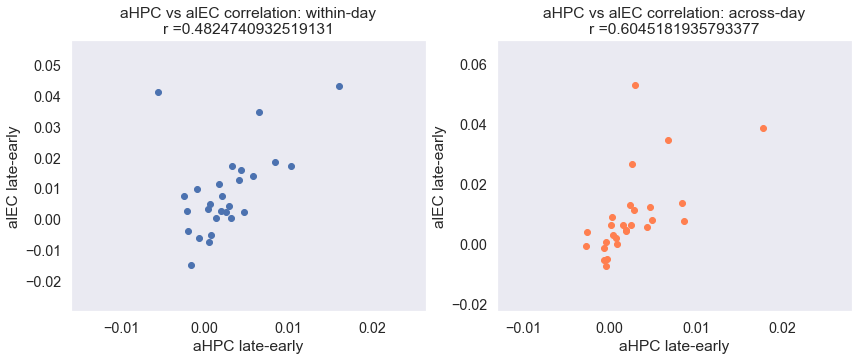

In [71]:
# Within
dt = 'within-day'
roi_df = rois_dict['aHPC']
df = roi_df.loc[roi_df.daytype == dt]
xa = df['late']
xb = df['early']

roi_df = rois_dict['alEC']
df = roi_df.loc[roi_df.daytype == dt]
ya = df['late']
yb = df['early']

# sns.set(style="dark",font_scale=1.3)
fig = plt.figure(figsize=(14,5))
# fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.subplot(1, 2, 1)
plt.scatter(xa-xb, ya-yb)
r = stats.pearsonr(xa-xb, ya-yb)[0]
plt.title("aHPC vs alEC correlation: " + dt + "\nr =" + str(r))
plt.xlabel("aHPC late-early")
plt.ylabel("alEC late-early")

# Across
dt = 'across-day'
roi_df = rois_dict['aHPC']
df = roi_df.loc[roi_df.daytype == dt]
xa = df['late']
xb = df['early']

roi_df = rois_dict['alEC']
df = roi_df.loc[roi_df.daytype == dt]
ya = df['late']
yb = df['early']

plt.subplot(1, 2, 2)
plt.scatter(xa-xb, ya-yb, c='coral')
r = stats.pearsonr(xa-xb, ya-yb)[0]
plt.title("aHPC vs alEC correlation: " + dt + "\nr =" + str(r))
plt.xlabel("aHPC late-early")
plt.ylabel("alEC late-early")
plt.show()

fig.savefig(join(behv_dir+'corr/'+"aHPC vs alEC corr.png"), dpi=90)

**Plot motion parameters**

In [94]:
motion_parm = ["mp" + str(num) for num in range(1,7)]
motion_parm

['mp1', 'mp2', 'mp3', 'mp4', 'mp5', 'mp6']

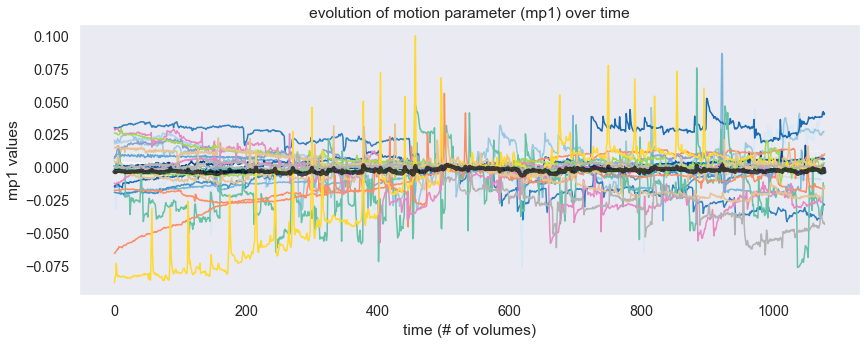

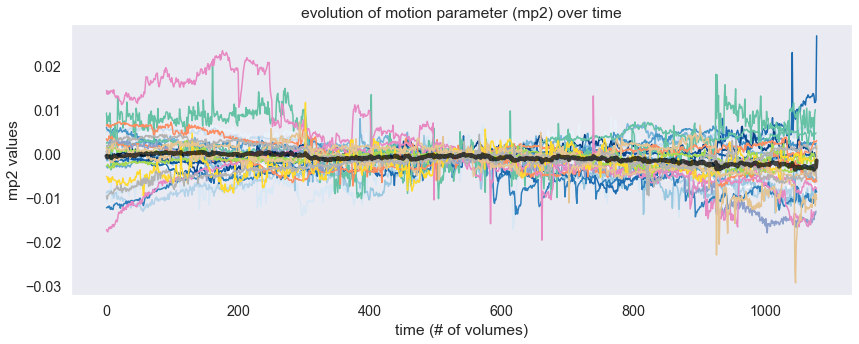

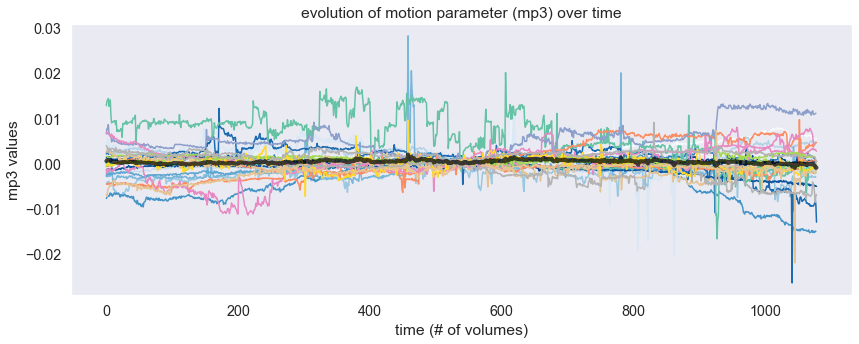

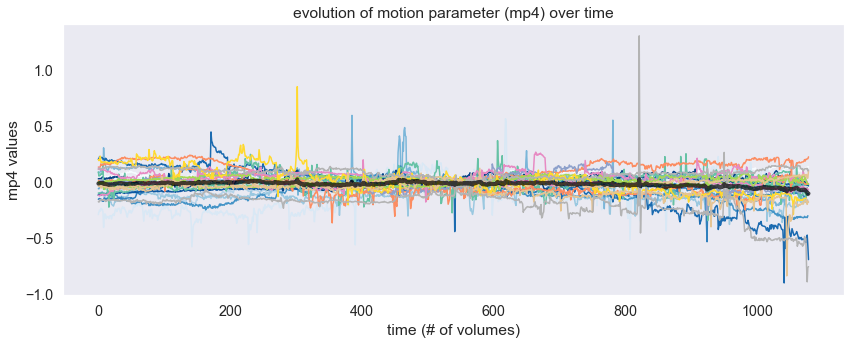

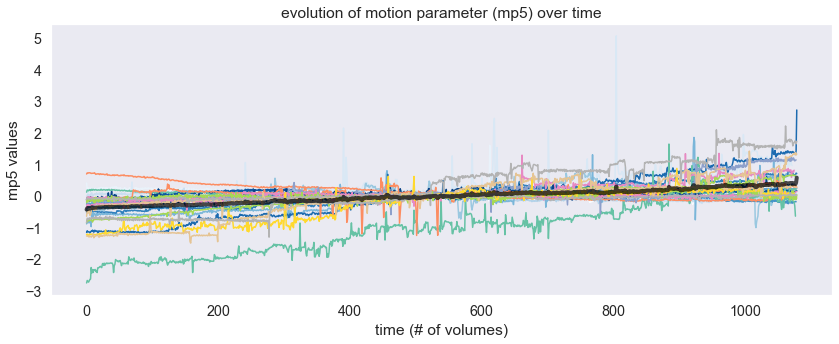

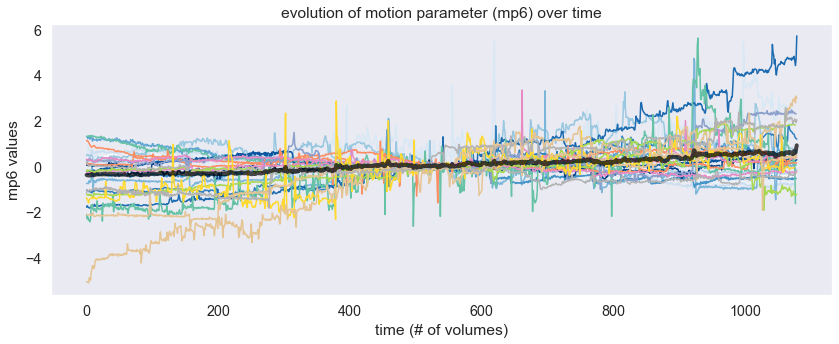

In [126]:
mps = {mp:pd.DataFrame(columns=participants) for mp in motion_parm}

for p in participants:
    # load the motion params and convert to a pandas dataframe
    mc_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mc/prefiltered_func_data_mcf_final.par"%p)
    mp_df = pd.read_csv(mc_dir, header=None, delimiter=r"\s+")
    mp_df.columns = motion_parm
    
    for mp in motion_parm:
        mps[mp][p] = mp_df[mp]

import matplotlib.colors as mcolors
c1 = plt.cm.Blues(np.linspace(0., 1, 128))
c2 = plt.cm.Set2(np.linspace(0, 1, 128))
colors = np.vstack((c1, c2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

for mp in motion_parm:
    #print(mp)
    ax = mps[mp].plot(figsize=(14,5), legend=False, cmap=mymap,
                      title="evolution of motion parameter (%s) over time" %mp)
    ax.set_xlabel("time (# of volumes)")
    ax.set_ylabel(mp + " values")
    mps[mp].mean(axis=1).plot(figsize=(14,5), legend=False, c='black', style=['-'], linewidth = 4, alpha=.7)
    
    #fig = ax.get_figure()
    #fig.savefig(mp + " _evol.png", dpi=90)

**Variance analysis of motion parameters**

In [100]:
mps_var = {mp:pd.DataFrame({'sub_id':participants, 'early':0, 'late':0}) for mp in motion_parm}

for p in participants:
    # load the motion params and convert to a pandas dataframe
    mc_dir = join(experiment_dir, "data/mri/processed/VIRTEM_%s/DLTASK.feat/mc/prefiltered_func_data_mcf_final.par"%p)
    mp_df = pd.read_csv(mc_dir, header=None, delimiter=r"\s+")
    mp_df.columns = motion_parm
    
    for mp in motion_parm:
        #print(mp)
        mpn = mp_df[mp]
        early = mpn.iloc[:int(mpn.size/2)] # 1st half
        late  = mpn.truncate(before = int(mpn.size/2)) # 2nd half
        
        mpvar = mps_var[mp]
        mpvar.loc[(mpvar.sub_id == p), 'early'] = np.var(early)
        mpvar.loc[(mpvar.sub_id == p), 'late'] = np.var(late)

mps_var['mp1'].head()

,sub_id,early,late
0,P031,0.000002,0.000002
1,P032,0.000001,0.000015
2,P033,0.000025,0.000198
3,P034,0.000001,0.000011
4,P035,0.000053,0.000004


In [127]:
def learningeffect_plt(mpdf, mp):
    a = mpdf['late']
    b = mpdf['early']
    assert_that(stats.ttest_rel(a, b), equal_to(stats.ttest_1samp(a-b, 0)))
    tstat, pval = stats.ttest_rel(a, b)
      
    mdf = pd.melt(mpdf, id_vars=["sub_id"], value_vars=["early", "late"], var_name="time", value_name="variance")

    sns.set(style="dark",font_scale=1.3)
    fig, ax = plt.subplots(1, 1, figsize=(6,7))
    sns.lineplot(x="time", y="variance", hue='sub_id', err_style="bars", ci=68, data=mdf,
                     legend=False, palette="gray_r")
    sns.scatterplot(x="time", y="variance", hue='sub_id', data=mdf, legend=False, palette="gray_r")
    sns.pointplot(x="time", y="variance", data=mdf, color='magenta', capsize=.03,
                  linestyles=['--']).set_title(mp + ':  tstat= %.4f,  pval= %.4f' %(tstat,pval))
    plt.show()

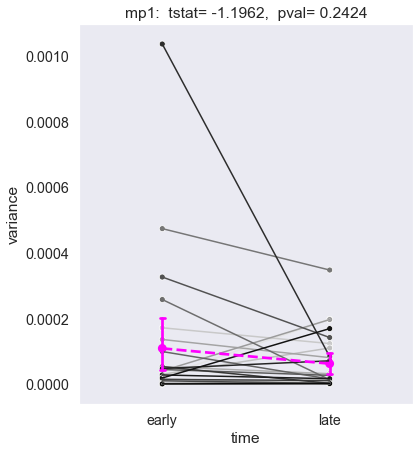

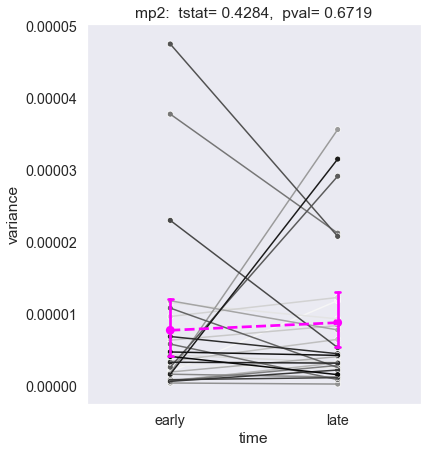

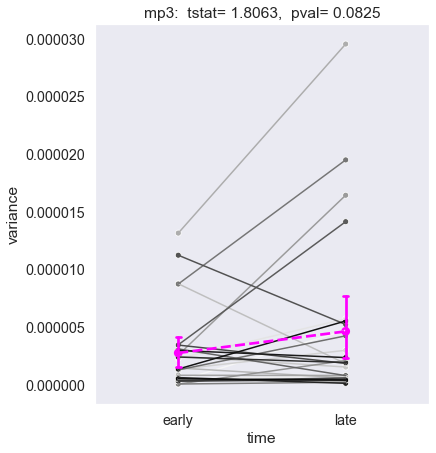

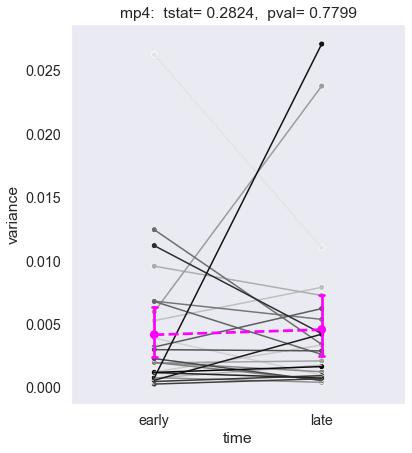

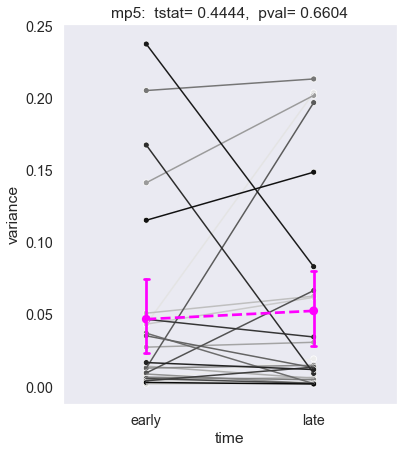

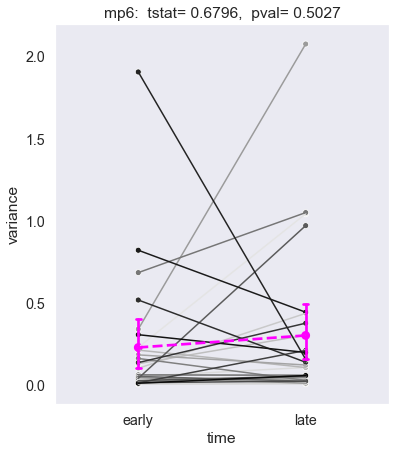

In [128]:
for mp in motion_parm:
    df = mps_var[mp]
    learningeffect_plt(df, mp)

# Low-dimensional projection